# Part I: Analyzing Transactions

A store is interested in determining relationships between items purchased from its Stationary and Health and Beauty Aids departments. They wish to conduct a market basket analysis of items purchased from these departments. transactions.csv contains information on 200,000 transactions made over a three-month period. The file has two columns – the transaction id (Transaction) and the product purchased (Product), and contains over 400,000 rows (as each row involves a single product, transactions involving multiple products span multiple rows). Seventeen products are represented in the data set: bar soap, bows, candy bars, deodorant, greeting cards, magazines, markers, pain relievers, pencils, pens, perfume, photo processing, prescription medications, shampoo, toothbrushes, toothpaste, and wrapping paper.

### 0. Setup

In [7]:
#pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import numpy as np
from statsmodels.imputation import mice
import statsmodels.api as sm
from sklearn import linear_model
from mlxtend.frequent_patterns import apriori, association_rules

### 1. Read in the data and generate a file in which every row represents a transaction, with True identifying items that were part of that transaction, and False identifying items that were not (as in the example from class). Name the file groupxxtransactions01.csv, where xx is your group number.

### 1-1. Read the dataset

In [25]:
df = pd.read_csv(r'transactions.csv')
df

,Transaction,Product
0,12359,Candy Bar
1,12362,Pain Reliever
2,12362,Pain Reliever
3,12365,Toothpaste
4,12371,Bow
...,...,...
459253,1221863,Candy Bar
459254,1221863,Greeting Cards
459255,1221863,Toothpaste
459256,1221863,Toothpaste


In [21]:
df.shape

(459258, 2)

In [22]:
df.describe()

,Transaction
count,4.592580e+05
mean,6.179884e+05
std,3.511578e+05
min,1.235900e+04
25%,3.124370e+05
50%,6.168260e+05
75%,9.254420e+05
max,1.221866e+06


In [26]:
df.set_index('Transaction', inplace = True)
df

,Product
Transaction,
12359,Candy Bar
12362,Pain Reliever
12362,Pain Reliever
12365,Toothpaste
12371,Bow
...,...
1221863,Candy Bar
1221863,Greeting Cards
1221863,Toothpaste


In [27]:
# One hot encoding for the column 'Product' to make every row represents a transaction
df = pd.get_dummies(df['Product'])
df

,Bow,Candy Bar,Deodorant,Greeting Cards,Magazine,Markers,Pain Reliever,Pencils,Pens,Perfume,Photo Processing,Prescription Med,Shampoo,Soap,Toothbrush,Toothpaste,Wrapping Paper
Transaction,,,,,,,,,,,,,,,,,
12359,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12362,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
12362,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
12365,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
12371,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221863,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1221863,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1221863,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [29]:
df = df.groupby('Transaction').sum().reset_index()
df

,Transaction,Bow,Candy Bar,Deodorant,Greeting Cards,Magazine,Markers,Pain Reliever,Pencils,Pens,Perfume,Photo Processing,Prescription Med,Shampoo,Soap,Toothbrush,Toothpaste,Wrapping Paper
0,12359,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,12362,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
2,12365,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,12371,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,12380,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,1221845,0,0,0,1,3,0,0,0,1,0,1,0,0,0,0,4,0
199996,1221854,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
199997,1221857,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
199998,1221863,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0


In [30]:
df.set_index('Transaction', inplace=True)
df

,Bow,Candy Bar,Deodorant,Greeting Cards,Magazine,Markers,Pain Reliever,Pencils,Pens,Perfume,Photo Processing,Prescription Med,Shampoo,Soap,Toothbrush,Toothpaste,Wrapping Paper
Transaction,,,,,,,,,,,,,,,,,
12359,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12362,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
12365,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
12371,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12380,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221845,0,0,0,1,3,0,0,0,1,0,1,0,0,0,0,4,0
1221854,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1221857,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
# Set True identifying items that were part of that transaction, and False identifying items that were not
df = df.astype(bool)
df

,Bow,Candy Bar,Deodorant,Greeting Cards,Magazine,Markers,Pain Reliever,Pencils,Pens,Perfume,Photo Processing,Prescription Med,Shampoo,Soap,Toothbrush,Toothpaste,Wrapping Paper
Transaction,,,,,,,,,,,,,,,,,
12359,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
12362,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
12365,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
12371,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
12380,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221845,False,False,False,True,True,False,False,False,True,False,True,False,False,False,False,True,False
1221854,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1221857,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [11]:
# Name the file groupxxtransactions01.csv, where xx is your group number.
df.to_csv("group06transactions01.csv", index = False)

### 2. Identify the frequent itemsets using a minimum support threshold of 1%. How many itemsets are frequent?

In [32]:
# identify frequent itemsets min_support 1% (0.01)
fi = apriori(df, min_support = 0.01, use_colnames = True)
fi

,support,itemsets
0,0.054645,(Bow)
1,0.171005,(Candy Bar)
2,0.146885,(Greeting Cards)
3,0.241305,(Magazine)
4,0.026700,(Pain Reliever)
5,0.134925,(Pencils)
6,0.143575,(Pens)
7,0.089960,(Perfume)
8,0.058480,(Photo Processing)
9,0.014505,(Prescription Med)


- 40 items are frequent at the threshold of 1%

### 3. Identify all association rules with a minimum confidence of 10%. How many rules are generated?

In [33]:
# Identify association rules at minimum threshold of 10% (0.10)
rules = association_rules(fi, metric="confidence", min_threshold=0.1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Bow),(Toothbrush),0.054645,0.067350,0.011340,0.207521,3.081236,0.007660,1.176877,0.714499
1,(Toothbrush),(Bow),0.067350,0.054645,0.011340,0.168374,3.081236,0.007660,1.136755,0.724232
2,(Candy Bar),(Greeting Cards),0.171005,0.146885,0.043660,0.255314,1.738191,0.018542,1.145604,0.512294
3,(Greeting Cards),(Candy Bar),0.146885,0.171005,0.043660,0.297239,1.738191,0.018542,1.179626,0.497810
4,(Magazine),(Candy Bar),0.241305,0.171005,0.040535,0.167982,0.982325,-0.000729,0.996367,-0.023167
5,(Candy Bar),(Magazine),0.171005,0.241305,0.040535,0.237040,0.982325,-0.000729,0.994410,-0.021244
6,(Candy Bar),(Pencils),0.171005,0.134925,0.033015,0.193065,1.430903,0.009942,1.072050,0.363260
7,(Pencils),(Candy Bar),0.134925,0.171005,0.033015,0.244691,1.430903,0.009942,1.097558,0.348109
8,(Toothpaste),(Candy Bar),0.160425,0.171005,0.039780,0.247966,1.450053,0.012347,1.102338,0.369675
9,(Candy Bar),(Toothpaste),0.171005,0.160425,0.039780,0.232625,1.450053,0.012347,1.094087,0.374393


- 50 rules are generated

### 4-i). Which rules have the highest lift?

In [39]:
# Sort the rules by lift
rules = rules.sort_values([ 'lift'], ascending =[False])
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
27,(Perfume),(Toothbrush),0.089960,0.067350,0.021820,0.242552,3.601370,0.015761,1.231306,0.793732
26,(Toothbrush),(Perfume),0.067350,0.089960,0.021820,0.323979,3.601370,0.015761,1.346172,0.774490
1,(Toothbrush),(Bow),0.067350,0.054645,0.011340,0.168374,3.081236,0.007660,1.136755,0.724232
0,(Bow),(Toothbrush),0.054645,0.067350,0.011340,0.207521,3.081236,0.007660,1.176877,0.714499
31,(Greeting Cards),"(Magazine, Candy Bar)",0.146885,0.040535,0.016665,0.113456,2.798966,0.010711,1.082253,0.753386
28,"(Magazine, Candy Bar)",(Greeting Cards),0.040535,0.146885,0.016665,0.411126,2.798966,0.010711,1.448723,0.669879
42,"(Toothpaste, Pencils)",(Candy Bar),0.024560,0.171005,0.011390,0.463762,2.711980,0.007190,1.545947,0.647160
29,"(Magazine, Greeting Cards)",(Candy Bar),0.036335,0.171005,0.016665,0.458649,2.682078,0.010452,1.531344,0.650802
47,"(Magazine, Toothpaste)",(Greeting Cards),0.031665,0.146885,0.011945,0.377230,2.568202,0.007294,1.369873,0.630590
38,"(Magazine, Toothpaste)",(Candy Bar),0.031665,0.171005,0.013720,0.433286,2.533762,0.008305,1.462810,0.625124


### 4-ii) Using the results from the previous questions, show exactly how this lift value was calculated for one of the rules with highest lift.

- According to our lecture notes, lift is calculated as
<center>lift = actual confidence / benchmark confidence</center>
- rule r: a --> c (i.e. antecedent --> consequent)
<center>lift(r) = sup(r)/[sup(a)*sup(c)] = conf(r) / sup(c)</center>
- In order to calculate this, we also need to get support
<center>support = # of transactions containing items in antecedent and consequent / # of transactions in database</center>

##### Let us show this with the given dataset, from Rule27 with the highest lift
- rule r: {Perfume} --> {Toothbrush}
- We are first going to extract the numbers of transactions of perume and/or toothbrush
- Then with the number, we are going to calcualte support and then lift in a consecutive order

In [68]:
# Transactions containing toothbrush and perfume
t_tp = len(df[(df['Toothbrush'] == True) & (df['Perfume'] == True)])
print("Transactions containing toothbrush and perfume:", t_tp)

# Transactions containing perfume
t_p = len(df[(df['Perfume'] == True)])
print("Transactions containing perfume:", t_p)

# Transactions containing toothbrush
t_t = len(df[(df['Toothbrush'] == True)])
print("Transactions containing toothbrush:", t_t)

# Total number of transactions in database
total = len(df)
print("Total number of transactions in database:", total)

Transactions containing toothbrush and perfume: 4364
Transactions containing perfume: 17992
Transactions containing toothbrush: 13470
Total number of transactions in database: 200000


In [69]:
# Support of toothbrush and perfume
sup_tp = t_tp / total
print("Support of toothbrush and perfume:", sup_tp)

# Support of perfume
sup_p = t_p / total
print("Support of perfume:", sup_p)

# Support of toothbrush
sup_t = t_t / total
print("Support of toothbrush:", sup_t)

Support of toothbrush and perfume: 0.02182
Support of perfume: 0.08996
Support of toothbrush: 0.06735


In [78]:
# Calculate the confidence of rule r
conf_r = sup_tp / sup_p
print("Confidence of rule r:", conf_r)

Confidence of rule r: 0.24255224544241885


In [79]:
# lift(r) = conf(r) / sup(c)
lift27 = conf_r / sup_t
print("Calculated lift:", lift27)

Calculated lift: 3.6013696427976076


- We got lift value 3.6013696427976076 for Rule 27.

In [76]:
rules['lift'][27]

3.6013696427976076

- The value we calcualted matches with the lift value we got from the dataframe.

### 5. For the same rule, show how leverage and conviction were obtained.

#### i) Leverage
<center>leverage(r) = p(c and a) - p(c) x p(a) = sup(r) - sup(c) x sup(a)</center>
- And we already got supports from Q4

In [84]:
# Recall support of toothbrush and perfume
print("Support of toothbrush and perfume:", sup_tp)

# Recall support of perfume
print("Support of perfume:", sup_p)

# Recall support of toothbrush
print("Support of toothbrush:", sup_t)

Support of toothbrush and perfume: 0.02182
Support of perfume: 0.08996
Support of toothbrush: 0.06735


In [85]:
lev_r = sup_tp - sup_p * sup_t
print(lev_r)

0.015761194


- We got leverage value 0.015761194 for Rule 27.

In [86]:
rules['leverage'][27]

0.015761194

- The value we calcualted matches with the leverage value we got from the dataframe.

#### ii) conviction
<center>conviction(r) = {1-p(c)} / {1-p(c|a)} = {1-sup(c)} / {1-conf(r)}</center> 
- And we already got support of toothbrush and confidence of rule r from Q4

In [80]:
# Recall support of toothbrush
print("Support of toothbrush:", sup_t)

# Recall confidence of rule r
print("Confidence of rule r:", conf_r)

Support of toothbrush: 0.06735
Confidence of rule r: 0.24255224544241885


In [83]:
conv_r = (1-sup_t) / (1-conf_r)
print("Calculated conviction:", conv_r)

Calculated conviction: 1.23130604637511


- We got conviction value 1.23130604637511 for Rule 27.

In [82]:
rules['conviction'][27]

1.23130604637511

- The value we calcualted matches with the conviction we got from the dataframe.

### 6. Interpret and discuss the 5 rules with
a. the highest confidence,
b. the highest lift,
c. the highest leverage, and
d. the highest conviction.
If there are more than five meeting the required criterion, pick any five. Are any of these surprising? Comment on the extent of their redundancy and utility.

#### a. the highest confidence

In [40]:
# Sort the rules by confidence
rules2 = rules.sort_values(['confidence'], ascending =[False])
rules2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
42,"(Toothpaste, Pencils)",(Candy Bar),0.024560,0.171005,0.011390,0.463762,2.711980,0.007190,1.545947,0.647160
29,"(Magazine, Greeting Cards)",(Candy Bar),0.036335,0.171005,0.016665,0.458649,2.682078,0.010452,1.531344,0.650802
38,"(Magazine, Toothpaste)",(Candy Bar),0.031665,0.171005,0.013720,0.433286,2.533762,0.008305,1.462810,0.625124
28,"(Magazine, Candy Bar)",(Greeting Cards),0.040535,0.146885,0.016665,0.411126,2.798966,0.010711,1.448723,0.669879
33,"(Toothpaste, Greeting Cards)",(Candy Bar),0.032080,0.171005,0.013175,0.410692,2.401637,0.007689,1.406726,0.602960
30,"(Candy Bar, Greeting Cards)",(Magazine),0.043660,0.241305,0.016665,0.381699,1.581813,0.006130,1.227065,0.384606
36,"(Magazine, Pencils)",(Candy Bar),0.031630,0.171005,0.012005,0.379545,2.219495,0.006596,1.336108,0.567394
47,"(Magazine, Toothpaste)",(Greeting Cards),0.031665,0.146885,0.011945,0.377230,2.568202,0.007294,1.369873,0.630590
46,"(Greeting Cards, Pencils)",(Magazine),0.029240,0.241305,0.010955,0.374658,1.552633,0.003899,1.213248,0.366654
49,"(Toothpaste, Greeting Cards)",(Magazine),0.032080,0.241305,0.011945,0.372350,1.543069,0.004204,1.208787,0.363605


#### b. the highest lift

In [41]:
# Sort the rules by lift
rules3 = rules.sort_values(['lift'], ascending =[False])
rules3

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
27,(Perfume),(Toothbrush),0.089960,0.067350,0.021820,0.242552,3.601370,0.015761,1.231306,0.793732
26,(Toothbrush),(Perfume),0.067350,0.089960,0.021820,0.323979,3.601370,0.015761,1.346172,0.774490
1,(Toothbrush),(Bow),0.067350,0.054645,0.011340,0.168374,3.081236,0.007660,1.136755,0.724232
0,(Bow),(Toothbrush),0.054645,0.067350,0.011340,0.207521,3.081236,0.007660,1.176877,0.714499
31,(Greeting Cards),"(Magazine, Candy Bar)",0.146885,0.040535,0.016665,0.113456,2.798966,0.010711,1.082253,0.753386
28,"(Magazine, Candy Bar)",(Greeting Cards),0.040535,0.146885,0.016665,0.411126,2.798966,0.010711,1.448723,0.669879
42,"(Toothpaste, Pencils)",(Candy Bar),0.024560,0.171005,0.011390,0.463762,2.711980,0.007190,1.545947,0.647160
29,"(Magazine, Greeting Cards)",(Candy Bar),0.036335,0.171005,0.016665,0.458649,2.682078,0.010452,1.531344,0.650802
47,"(Magazine, Toothpaste)",(Greeting Cards),0.031665,0.146885,0.011945,0.377230,2.568202,0.007294,1.369873,0.630590
38,"(Magazine, Toothpaste)",(Candy Bar),0.031665,0.171005,0.013720,0.433286,2.533762,0.008305,1.462810,0.625124


#### c. the highest leverage

In [42]:
# Sort the rules by leverage
rules4 = rules.sort_values(['leverage'], ascending =[False])
rules4

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
3,(Greeting Cards),(Candy Bar),0.146885,0.171005,0.043660,0.297239,1.738191,0.018542,1.179626,0.497810
2,(Candy Bar),(Greeting Cards),0.171005,0.146885,0.043660,0.255314,1.738191,0.018542,1.145604,0.512294
27,(Perfume),(Toothbrush),0.089960,0.067350,0.021820,0.242552,3.601370,0.015761,1.231306,0.793732
26,(Toothbrush),(Perfume),0.067350,0.089960,0.021820,0.323979,3.601370,0.015761,1.346172,0.774490
8,(Toothpaste),(Candy Bar),0.160425,0.171005,0.039780,0.247966,1.450053,0.012347,1.102338,0.369675
9,(Candy Bar),(Toothpaste),0.171005,0.160425,0.039780,0.232625,1.450053,0.012347,1.094087,0.374393
31,(Greeting Cards),"(Magazine, Candy Bar)",0.146885,0.040535,0.016665,0.113456,2.798966,0.010711,1.082253,0.753386
28,"(Magazine, Candy Bar)",(Greeting Cards),0.040535,0.146885,0.016665,0.411126,2.798966,0.010711,1.448723,0.669879
29,"(Magazine, Greeting Cards)",(Candy Bar),0.036335,0.171005,0.016665,0.458649,2.682078,0.010452,1.531344,0.650802
6,(Candy Bar),(Pencils),0.171005,0.134925,0.033015,0.193065,1.430903,0.009942,1.072050,0.363260


#### d. the highest conviction

In [43]:
# Sort the rules by conviction
rules5 = rules.sort_values(['conviction'], ascending =[False])
rules5

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
42,"(Toothpaste, Pencils)",(Candy Bar),0.024560,0.171005,0.011390,0.463762,2.711980,0.007190,1.545947,0.647160
29,"(Magazine, Greeting Cards)",(Candy Bar),0.036335,0.171005,0.016665,0.458649,2.682078,0.010452,1.531344,0.650802
38,"(Magazine, Toothpaste)",(Candy Bar),0.031665,0.171005,0.013720,0.433286,2.533762,0.008305,1.462810,0.625124
28,"(Magazine, Candy Bar)",(Greeting Cards),0.040535,0.146885,0.016665,0.411126,2.798966,0.010711,1.448723,0.669879
33,"(Toothpaste, Greeting Cards)",(Candy Bar),0.032080,0.171005,0.013175,0.410692,2.401637,0.007689,1.406726,0.602960
47,"(Magazine, Toothpaste)",(Greeting Cards),0.031665,0.146885,0.011945,0.377230,2.568202,0.007294,1.369873,0.630590
26,(Toothbrush),(Perfume),0.067350,0.089960,0.021820,0.323979,3.601370,0.015761,1.346172,0.774490
36,"(Magazine, Pencils)",(Candy Bar),0.031630,0.171005,0.012005,0.379545,2.219495,0.006596,1.336108,0.567394
45,"(Magazine, Pencils)",(Greeting Cards),0.031630,0.146885,0.010955,0.346348,2.357956,0.006309,1.305152,0.594715
43,"(Candy Bar, Pencils)",(Toothpaste),0.033015,0.160425,0.011390,0.344995,2.150505,0.006094,1.281784,0.553259


## 6e. If there are more than five meeting the required criterion, pick any five. Are any of these surprising? Comment on the extent of their redundancy and utility. 

#### Analysis:
We obtained distinct lists of the rules by applying the various criteria, however comparing these lists could give us a better guide to choose the best rules, such as:
- {Greeting Cards} and {Candy Bar} are included in several rules, either as antecedents or as consequences, indicating a strong correlation between these two things.
- The rule that has "Candy Bar" as the consequent and "Toothpaste" as the antecedent appears more than once, suggesting a stronger correlation.
- Rules with the products "Magazine" and "Candy Bar", frequently occur in the top rankings; These three elements are the most highly related when they occasionally come together as a set that appears as an antecedent or consequent set.
- There are two rules with strong certainty in the list that have "Toothbrush" and "Perfume"as either the antecedent or the consequent, demonstrating their correlation.

As for Redundancy, we do have rules that seem redundant and has 0 utility in the sense that they basically offer the same insight, i.e. duplicates or rules that have the antecedent and consequent swapped.

If we examine the lift-sorted rules that were developed. It is evident that the relationship between {Toothbrush} and {Perfume} has higher confidence than the relationship between {Perfume} and {Toothbrush}. Support, lift, and leverage are all unchanged, but the conviction is higher. If the relationship between a and b was solely due to chance, rule 1 would be incorrect 23% more frequently, whereas rule 3 would be incorrect 35% more frequently. Even if rule 2 has a higher probability of being accurate, we will select it and disregard rule 1 due to its related cost and margin.

### 7. Do any of these metrics seem preferable to the others for this dataset? Discuss why or why not.

The rules we prefer depends on the objectives of this analysis. 
- If we want to know what is the most reliable product sets we tend to sell, the highest confidence will give us that metric
- If we want to know which rules are more meaningful than a random chance, we look at lift
- Leverage offers insights into deviation from independence which tends to be niche in my opinion
- Finally, Conviction shows the impact of the anteceddent on the consequent.

In this case, Lift would be the preferred metric. Due to the Following reasons:
- We can easily remove redundant rules with the lift metric, same lift with 1 element in each antecedent and consequent would make a rule potentially removable
- It is particularly useful for identifying rules that have practical significance and are not just a result of the overall frequency of the items in the dataset.
- A lift of 1 indicates independence, values greater than 1 indicate positive association, and values less than 1 indicate a negative association. This simplicity makes lift accessible to both analysts and stakeholders.
- We can select rules with lift values above a certain threshold to focus on associations that are more meaningful and relevant to our objectives.

### 8. If you were in charge of these departments, how would you use the results of this analysis to come up with a strategic plan? Explain your reasoning. This question is open ended, and I am looking for innovative thinking.

Assuming I am in charge of these departments, I have the following actionable items:
- By combining the transactions with consumer information, we may enhance our marketing campaigns and send out more targeted mailings and email ideas. 
- Together, we may also modify the price and profit margins. One item can be placed on sale while the price of the other is raised.
- Things that are highly associated can be arranged on shelves so that they are closer together. Examples of such things include toothpaste and candy bars, greeting cards, magazines, toothbrushes, and perfume. 
- By offering a percentage of a discount to clients who purchase the linked things together, we can bind the highly associated products in the sales process.

# Part II: Clustering Customers

A bank in the U.K. is interested in identifying categories of customers for potential future promotions. Data collected on 600 customers is in bankcustomers.csv; the variables involved are below.

### 1. Notice that region is categorical; we need to do what is referred to as “one-hot encoding” – convert it into separate (binary) variables, one for each possible value of region. So you will need to create 4 new variables, corresponding to inner city, town, rural, and suburban (a 1 in a column would represent being from the associated region). You can do this either explicitly by writing your own code, or by using the OneHotEncoder option available in sklearn (preprocessing). Read in the data, create the four new columns, and drop region.

In [115]:
# Read the dataset
df2 = pd.read_csv(r'bankcustomers.csv')
df2

,Unnamed: 0,id,age,sex,region,income,married,children,car,savings,checking,mortgage,pep
0,0,ID12101,48,1,1,17546.00,0,1,0,0,0,0,1
1,1,ID12102,40,0,2,30085.10,1,3,1,0,1,1,0
2,2,ID12103,51,1,1,16575.40,1,0,1,1,1,0,0
3,3,ID12104,23,1,2,20375.40,1,3,0,0,1,0,0
4,4,ID12105,57,1,3,50576.30,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,595,ID12696,61,1,1,47025.00,0,2,1,1,1,1,0
596,596,ID12697,30,1,1,9672.25,1,0,1,1,1,0,0
597,597,ID12698,31,1,2,15976.30,1,0,1,1,0,0,1
598,598,ID12699,29,0,1,14711.80,1,0,0,1,0,1,0


In [125]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        600 non-null    object 
 1   age       600 non-null    int64  
 2   sex       600 non-null    int64  
 3   income    600 non-null    float64
 4   married   600 non-null    int64  
 5   children  600 non-null    int64  
 6   car       600 non-null    int64  
 7   savings   600 non-null    int64  
 8   checking  600 non-null    int64  
 9   mortgage  600 non-null    int64  
 10  pep       600 non-null    int64  
 11  city      600 non-null    uint8  
 12  town      600 non-null    uint8  
 13  rural     600 non-null    uint8  
 14  suburban  600 non-null    uint8  
dtypes: float64(1), int64(9), object(1), uint8(4)
memory usage: 54.0+ KB


In [88]:
df2.shape

(600, 13)

In [90]:
df2.describe()

,Unnamed: 0,age,sex,region,income,married,children,car,savings,checking,mortgage,pep
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,299.500000,42.395000,0.500000,1.918333,27524.031217,0.660000,1.011667,0.493333,0.690000,0.758333,0.348333,0.456667
std,173.349358,14.424947,0.500417,1.008311,12899.468246,0.474104,1.056752,0.500373,0.462879,0.428451,0.476840,0.498534
min,0.000000,18.000000,0.000000,1.000000,5014.210000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,149.750000,30.000000,0.000000,1.000000,17264.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,299.500000,42.000000,0.500000,2.000000,24925.300000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,449.250000,55.250000,1.000000,3.000000,36172.675000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,599.000000,67.000000,1.000000,4.000000,63130.100000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [111]:
# One hot encoding for the column 'Product' to make every row represents a transaction
df2_region = pd.get_dummies(df2['region'])
df2_region

,1,2,3,4
0,1,0,0,0
1,0,1,0,0
2,1,0,0,0
3,0,1,0,0
4,0,0,1,0
...,...,...,...,...
595,1,0,0,0
596,1,0,0,0
597,0,1,0,0
598,1,0,0,0


In [112]:
# Create the four new columns
df2_region.columns =['city', 'town', 'rural', 'suburban']
df2_region.head()

,city,town,rural,suburban
0,1,0,0,0
1,0,1,0,0
2,1,0,0,0
3,0,1,0,0
4,0,0,1,0


In [116]:
# Drop region
df2 = pd.concat([df2, df2_region], axis=1)
df2 = df2.drop(['Unnamed: 0','region'], axis=1)
df2

,id,age,sex,income,married,children,car,savings,checking,mortgage,pep,city,town,rural,suburban
0,ID12101,48,1,17546.00,0,1,0,0,0,0,1,1,0,0,0
1,ID12102,40,0,30085.10,1,3,1,0,1,1,0,0,1,0,0
2,ID12103,51,1,16575.40,1,0,1,1,1,0,0,1,0,0,0
3,ID12104,23,1,20375.40,1,3,0,0,1,0,0,0,1,0,0
4,ID12105,57,1,50576.30,1,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,ID12696,61,1,47025.00,0,2,1,1,1,1,0,1,0,0,0
596,ID12697,30,1,9672.25,1,0,1,1,1,0,0,1,0,0,0
597,ID12698,31,1,15976.30,1,0,1,1,0,0,1,0,1,0,0
598,ID12699,29,0,14711.80,1,0,0,1,0,1,0,1,0,0,0


### 2-i). Apply hierarchical clustering (with Euclidian distance as the measure of distance) to the dataset using (i) centroid linkage, (ii) single linkage, (iii) complete linkage, (iv) average linkage, and (v) Ward linkage. For each of these, comment on whether you see any clear clusters, and how many clusters you would recommend (and why). 

In [137]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hc
from sklearn.preprocessing import normalize
#from scipy.cluster.hierarchy import fcluster, dendrogram, linkage

In [118]:
# Count missing values
df2.isna().sum() #no missing values

id          0
age         0
sex         0
income      0
married     0
children    0
car         0
savings     0
checking    0
mortgage    0
pep         0
city        0
town        0
rural       0
suburban    0
dtype: int64

In [119]:
len(df2)

600

In [126]:
# Create a dataframe with the numeric variables
df2 = df2.drop('id', axis = 1)
df2.head()

,age,sex,income,married,children,car,savings,checking,mortgage,pep,city,town,rural,suburban
0,48,1,17546.0,0,1,0,0,0,0,1,1,0,0,0
1,40,0,30085.1,1,3,1,0,1,1,0,0,1,0,0
2,51,1,16575.4,1,0,1,1,1,0,0,1,0,0,0
3,23,1,20375.4,1,3,0,0,1,0,0,0,1,0,0
4,57,1,50576.3,1,0,0,1,0,0,0,0,0,1,0


In [128]:
# Normalize the data and place in a dataframe
ndf2 = normalize(df2)
ndf2 = pd.DataFrame(ndf2, columns=df2.columns)
ndf2

,age,sex,income,married,children,car,savings,checking,mortgage,pep,city,town,rural,suburban
0,0.002736,0.000057,0.999996,0.000000,0.000057,0.000000,0.000000,0.000000,0.000000,0.000057,0.000057,0.000000,0.00000,0.0
1,0.001330,0.000000,0.999999,0.000033,0.000100,0.000033,0.000000,0.000033,0.000033,0.000000,0.000000,0.000033,0.00000,0.0
2,0.003077,0.000060,0.999995,0.000060,0.000000,0.000060,0.000060,0.000060,0.000000,0.000000,0.000060,0.000000,0.00000,0.0
3,0.001129,0.000049,0.999999,0.000049,0.000147,0.000000,0.000000,0.000049,0.000000,0.000000,0.000000,0.000049,0.00000,0.0
4,0.001127,0.000020,0.999999,0.000020,0.000000,0.000000,0.000020,0.000000,0.000000,0.000000,0.000000,0.000000,0.00002,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.001297,0.000021,0.999999,0.000000,0.000043,0.000021,0.000021,0.000021,0.000021,0.000000,0.000021,0.000000,0.00000,0.0
596,0.003102,0.000103,0.999995,0.000103,0.000000,0.000103,0.000103,0.000103,0.000000,0.000000,0.000103,0.000000,0.00000,0.0
597,0.001940,0.000063,0.999998,0.000063,0.000000,0.000063,0.000063,0.000000,0.000000,0.000063,0.000000,0.000063,0.00000,0.0
598,0.001971,0.000000,0.999998,0.000068,0.000000,0.000000,0.000068,0.000000,0.000068,0.000000,0.000068,0.000000,0.00000,0.0


### (i) Hierarchical Clustering: Centroid Linkage

In [138]:
clstr1 = hc.linkage(ndf2, method='centroid', metric="euclidean")

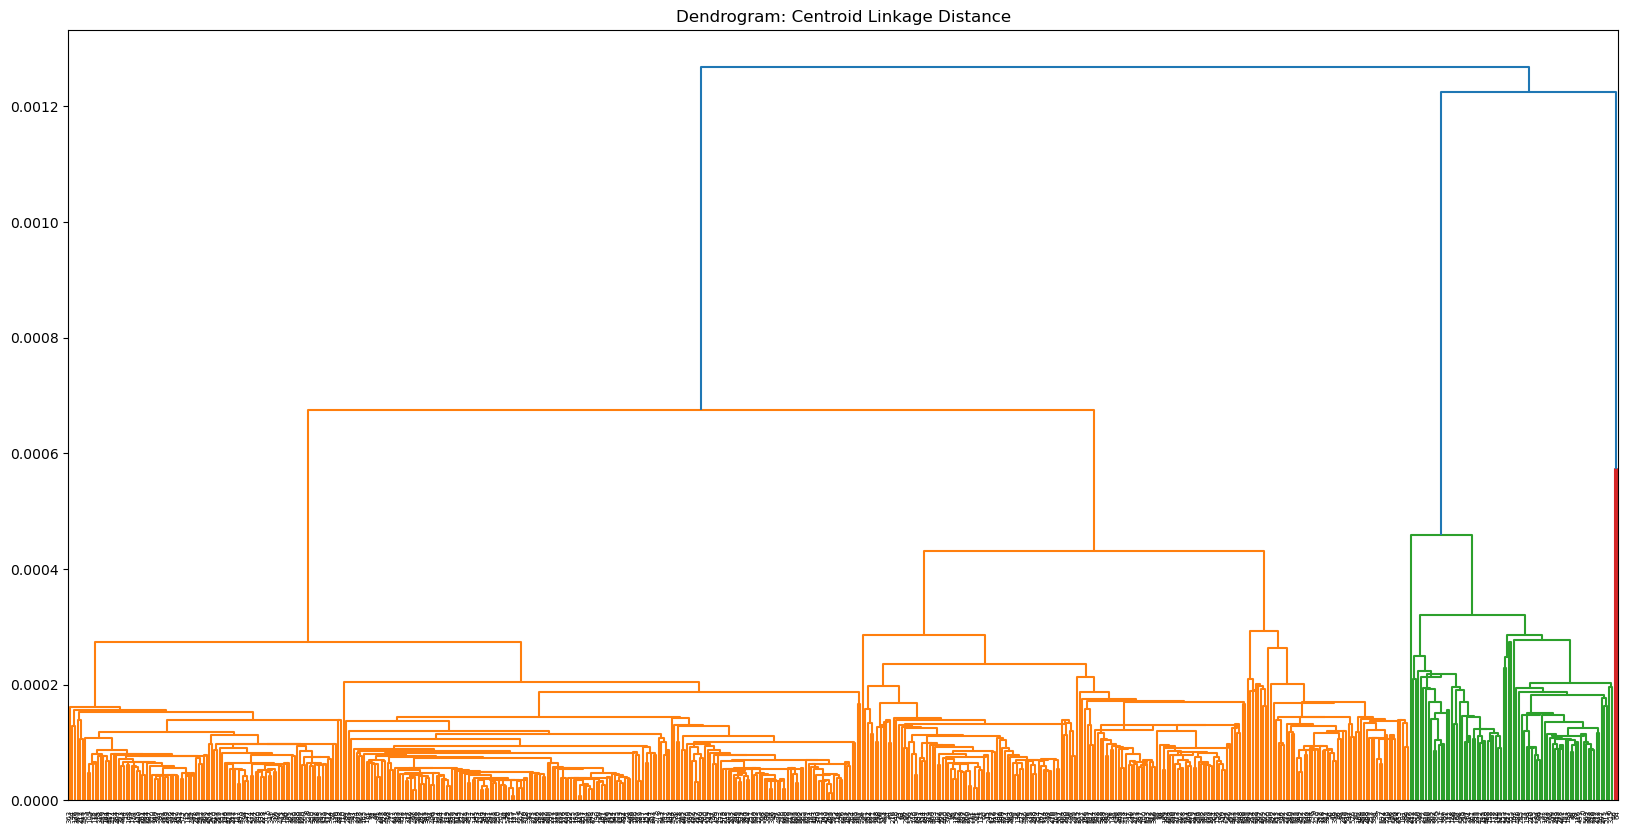

In [142]:
plt.figure(figsize=(20, 10))  
plt.title("Dendrogram: Centroid Linkage Distance")
dgclstr1 = dendrogram(clstr1)
plt.show() 

In [184]:
max(clstr1[:,2])

0.0012683363624996118

In [189]:
clstr1[-20:,2] #largest value associated with the final merger

array([0.00021353, 0.00022277, 0.00022921, 0.00023564, 0.0002494 ,
       0.00026313, 0.00027272, 0.00024739, 0.0002736 , 0.00027644,
       0.00028522, 0.00028569, 0.00029312, 0.00031995, 0.00043098,
       0.00045774, 0.00057302, 0.0006751 , 0.00122477, 0.00126834])

In [201]:
# Identify cluster membership
maxdist1 = 0.0008
clusters = fcluster(clstr1, maxdist1, criterion='distance')
clusters

array([2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1,
       1, 1, 3, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1,
       1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,

In [202]:
len(clusters)

600

In [203]:
# Add the cluster id to the original datasetb
df21 = df2.copy()
df21['CLUSTER'] = clusters.tolist()
df21

,age,sex,income,married,children,car,savings,checking,mortgage,pep,city,town,rural,suburban,CLUSTER
0,48,1,17546.00,0,1,0,0,0,0,1,1,0,0,0,2
1,40,0,30085.10,1,3,1,0,1,1,0,0,1,0,0,1
2,51,1,16575.40,1,0,1,1,1,0,0,1,0,0,0,2
3,23,1,20375.40,1,3,0,0,1,0,0,0,1,0,0,1
4,57,1,50576.30,1,0,0,1,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,61,1,47025.00,0,2,1,1,1,1,0,1,0,0,0,1
596,30,1,9672.25,1,0,1,1,1,0,0,1,0,0,0,2
597,31,1,15976.30,1,0,1,1,0,0,1,0,1,0,0,1
598,29,0,14711.80,1,0,0,1,0,1,0,1,0,0,0,1


In [204]:
# Get the averages of all the columns by cluster ID to try and identify cluster characteristics
# And review the cluster characteristics
df21Avg = df21.groupby('CLUSTER', as_index=False).mean()
df21Avg

,CLUSTER,age,sex,income,married,children,car,savings,checking,mortgage,pep,city,town,rural,suburban
0,1,42.277457,0.493256,29388.944297,0.66474,1.015414,0.508671,0.709056,0.766859,0.348748,0.470135,0.439306,0.290944,0.167630,0.102119
1,2,43.341772,0.544304,15737.449747,0.64557,1.000000,0.379747,0.556962,0.696203,0.341772,0.367089,0.506329,0.265823,0.113924,0.113924
2,3,35.500000,0.500000,9149.055000,0.00000,0.500000,1.000000,1.000000,1.000000,0.500000,0.500000,0.500000,0.500000,0.000000,0.000000


- 3 clear clusters can be seen from the dendrogram.
- Characteristics of each cluster:
- Cluster 0: middle-aged (42.28), financially stable individuals (income 29388.94, and higher savings/checking/personal equity plan(pep) compared to Cluster 1 or 2), with families (highet average in married and children), mostly living in urban and rural areas (city (43.93%), town (29.10%), whereas rural (16.76%) and suburban (16.8%)).
- Cluster 1: slightly older individuals (43.34) than Cluster 0, with less income (15737.45), also primarily urban dwellers (over half in city (50.63%) and town (26.58%)) but with fewer resources like cars (37.97%) and less savings/checking accounts (55.70% and 69.6% respectively).
- Cluster 2: younger (35.50), unmarried (0%) individuals with lower incomes (9149.05 on avg), but all have cars (100%) and savings/checking accounts(100%). Lastly, living either in city(50%) or town(50%).

### (ii) Hierarchical Clustering: single linkage

In [143]:
clstr2 = hc.linkage(ndf2, method='single', metric="euclidean")

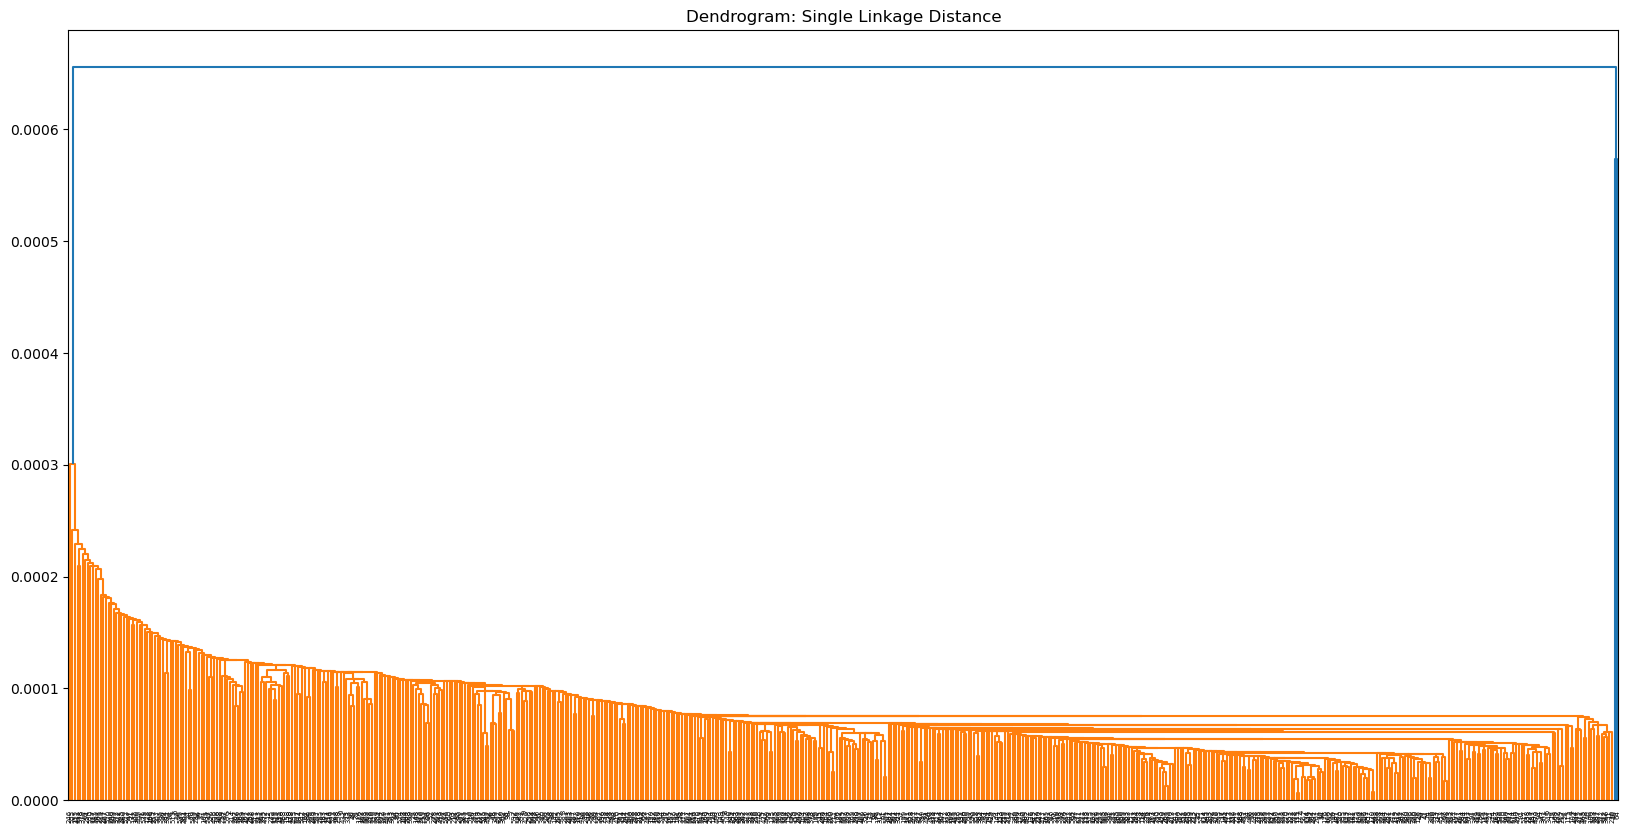

In [146]:
plt.figure(figsize=(20, 10))  
plt.title("Dendrogram: Single Linkage Distance")
dgclstr2 = hc.dendrogram(clstr2)
plt.show()

In [185]:
max(clstr2[:,2])

0.0006558557302763839

In [190]:
clstr2[-20:,2] #largest value associated with the final merger

array([0.0001713 , 0.00017552, 0.0001764 , 0.00018118, 0.00018162,
       0.00018368, 0.00019808, 0.00020694, 0.000209  , 0.00020935,
       0.00020937, 0.00021174, 0.00021475, 0.00022035, 0.00022479,
       0.00022921, 0.00024118, 0.00030081, 0.00057302, 0.00065586])

In [212]:
# Identify cluster membership
maxdist2 = 0.00035
clusters2 = fcluster(clstr2, maxdist2, criterion='distance')
clusters2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [213]:
# Add the cluster id to the original datasetb
df22 = df2.copy()
df22['CLUSTER'] = clusters2.tolist()
df22

,age,sex,income,married,children,car,savings,checking,mortgage,pep,city,town,rural,suburban,CLUSTER
0,48,1,17546.00,0,1,0,0,0,0,1,1,0,0,0,1
1,40,0,30085.10,1,3,1,0,1,1,0,0,1,0,0,1
2,51,1,16575.40,1,0,1,1,1,0,0,1,0,0,0,1
3,23,1,20375.40,1,3,0,0,1,0,0,0,1,0,0,1
4,57,1,50576.30,1,0,0,1,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,61,1,47025.00,0,2,1,1,1,1,0,1,0,0,0,1
596,30,1,9672.25,1,0,1,1,1,0,0,1,0,0,0,1
597,31,1,15976.30,1,0,1,1,0,0,1,0,1,0,0,1
598,29,0,14711.80,1,0,0,1,0,1,0,1,0,0,0,1


In [214]:
# Get the averages of all the columns by cluster ID to try and identify cluster characteristics
# And review the cluster characteristics
df22Avg = df22.groupby('CLUSTER', as_index=False).mean()
df22Avg

,CLUSTER,age,sex,income,married,children,car,savings,checking,mortgage,pep,city,town,rural,suburban
0,1,42.41806,0.5,27585.485987,0.662207,1.013378,0.491639,0.688963,0.757525,0.347826,0.456522,0.448161,0.287625,0.160535,0.103679
1,2,50.00000,1.0,13283.900000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
2,3,21.00000,0.0,5014.210000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000


- 3 clear clusters can be seen from the dendrogram.
- Characteristics of each cluster:
- Cluster 0: middle-aged (42.42), financially stable individuals (income 27585.49, and higher savings/checking/personal equity plan(pep) compared to Cluster 1 or 2), with families (highet average in married and the number of children), mostly living in urban and rural areas (city (44.82%), town (28.76%), whereas rural (16.76%) and suburban (16.8%)) but still higher rates living in rural or suburb areas compared to Cluster 1 and 2.
- Cluster 1: slightly older (50.0) than Cluster 0, female group with less income (13283.90), all city dwellers (100% in city). Not married (0) but have 1 child on average, on average all owning cars/saving/checking and equity plan.
- Cluster 2: younger (21.0) male group, unmarried (0%) individuals with lower incomes (5014.21 on avg), all have cars (100%) and savings/checking accounts(100%). Lastly, living town(100%).

### (iii) Hierarchical Clustering: complete linkage

In [148]:
clstr3 = hc.linkage(df2, method='complete', metric="euclidean")

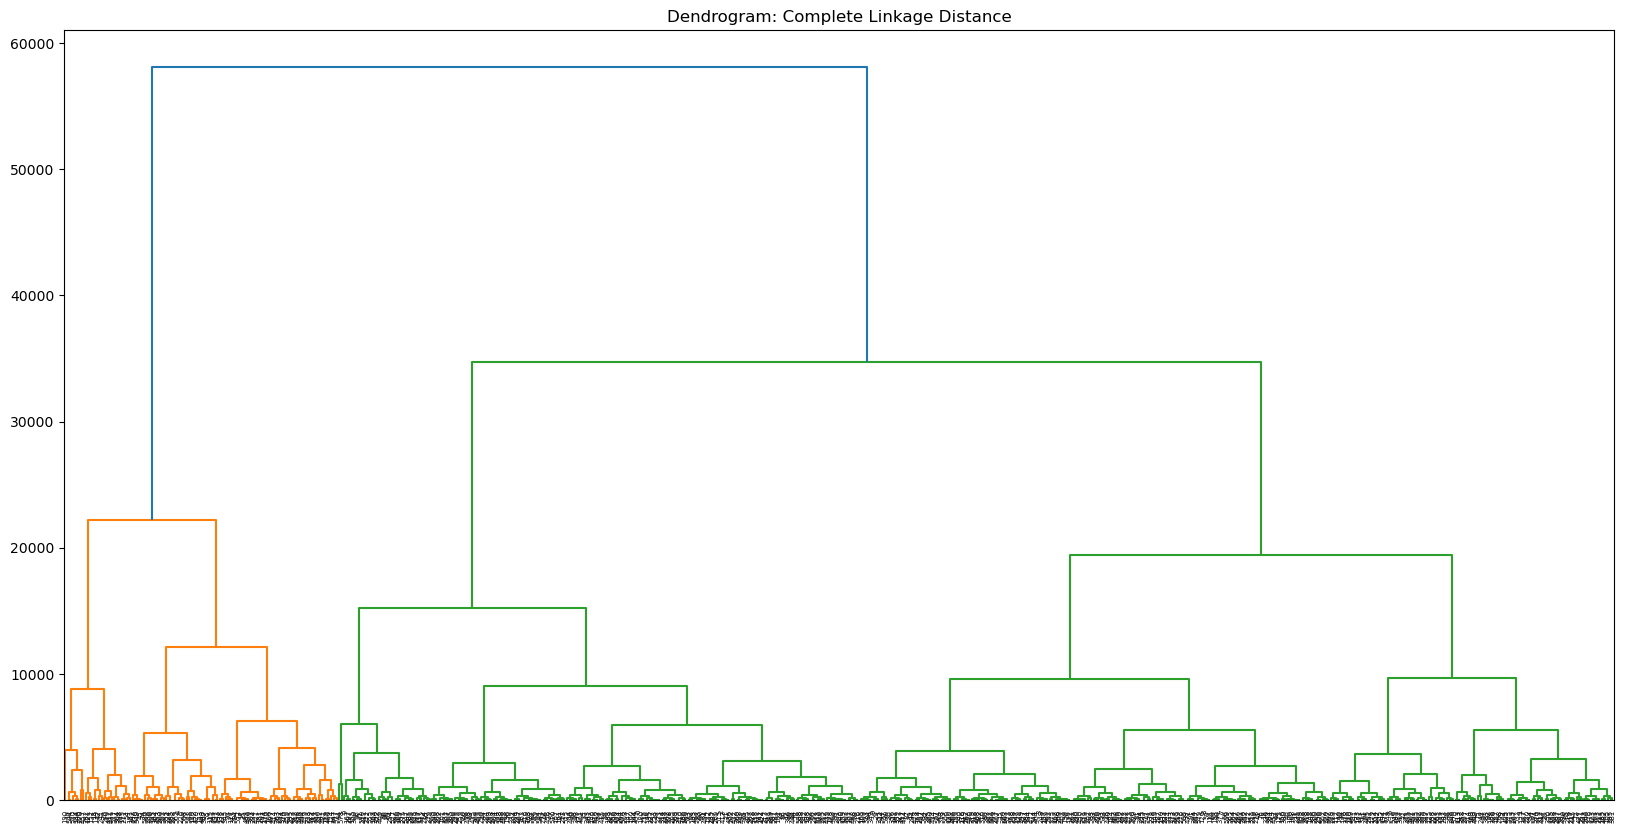

In [149]:
plt.figure(figsize=(20, 10))  
plt.title("Dendrogram: Complete Linkage Distance")
dgclstr3 = hc.dendrogram(clstr3)
plt.show()

In [186]:
max(clstr3[:,2])

58115.908291035936

In [191]:
clstr3[-20:,2] #largest value associated with the final merger

array([ 3923.15722474,  3955.00151707,  4052.80049349,  4141.64430631,
        5354.10607011,  5543.00063143,  5574.70062784,  5977.55294832,
        6058.79115535,  6248.7057612 ,  8815.60079405,  9052.73501711,
        9574.30287227,  9677.80459815, 12154.40115185, 15253.81399402,
       19398.3029384 , 22180.20164561, 34731.10216489, 58115.90829104])

In [215]:
# Identify cluster membership
maxdist3 = 30000
clusters3 = fcluster(clstr3, maxdist3, criterion='distance')
clusters3

array([2, 3, 2, 3, 1, 3, 2, 3, 3, 3, 1, 3, 2, 1, 2, 3, 2, 1, 3, 3, 1, 2,
       3, 2, 2, 1, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 1, 3,
       2, 1, 2, 2, 3, 2, 2, 3, 2, 3, 1, 1, 3, 3, 2, 3, 3, 3, 3, 2, 2, 2,
       2, 3, 2, 2, 2, 2, 3, 3, 1, 3, 3, 1, 2, 3, 3, 3, 2, 2, 3, 3, 2, 3,
       2, 3, 3, 3, 3, 1, 1, 2, 2, 3, 2, 2, 3, 2, 2, 3, 3, 3, 1, 2, 2, 3,
       3, 3, 3, 3, 1, 1, 3, 2, 2, 1, 3, 1, 3, 3, 1, 3, 3, 1, 2, 3, 3, 1,
       2, 3, 1, 3, 2, 3, 1, 1, 3, 3, 2, 1, 2, 1, 2, 2, 3, 3, 3, 3, 1, 3,
       3, 2, 3, 3, 3, 2, 2, 2, 3, 2, 3, 3, 2, 2, 3, 3, 1, 2, 3, 3, 1, 1,
       3, 3, 2, 3, 2, 1, 3, 2, 3, 3, 2, 3, 3, 3, 1, 2, 1, 2, 3, 2, 2, 1,
       2, 3, 3, 1, 2, 2, 2, 2, 1, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 1, 3, 1, 1, 3, 1, 3, 3, 2, 3, 3, 2, 3, 1, 2, 1, 2, 2, 2, 2, 1,
       3, 2, 3, 3, 2, 3, 3, 3, 1, 3, 2, 2, 2, 3, 3, 3, 3, 2, 2, 3, 3, 1,
       2, 2, 3, 3, 3, 2, 1, 1, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 1, 3, 2, 2,
       3, 3, 2, 3, 2, 3, 1, 3, 3, 3, 3, 2, 2, 2, 2,

In [216]:
# Add the cluster id to the original datasetb
df23 = df2.copy()
df23['CLUSTER'] = clusters3.tolist()
df23

,age,sex,income,married,children,car,savings,checking,mortgage,pep,city,town,rural,suburban,CLUSTER
0,48,1,17546.00,0,1,0,0,0,0,1,1,0,0,0,2
1,40,0,30085.10,1,3,1,0,1,1,0,0,1,0,0,3
2,51,1,16575.40,1,0,1,1,1,0,0,1,0,0,0,2
3,23,1,20375.40,1,3,0,0,1,0,0,0,1,0,0,3
4,57,1,50576.30,1,0,0,1,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,61,1,47025.00,0,2,1,1,1,1,0,1,0,0,0,1
596,30,1,9672.25,1,0,1,1,1,0,0,1,0,0,0,2
597,31,1,15976.30,1,0,1,1,0,0,1,0,1,0,0,2
598,29,0,14711.80,1,0,0,1,0,1,0,1,0,0,0,2


In [217]:
# Get the averages of all the columns by cluster ID to try and identify cluster characteristics
# And review the cluster characteristics
df23Avg = df23.groupby('CLUSTER', as_index=False).mean()
df23Avg

,CLUSTER,age,sex,income,married,children,car,savings,checking,mortgage,pep,city,town,rural,suburban
0,1,59.056604,0.500000,49258.906604,0.679245,1.075472,0.509434,1.000000,0.801887,0.320755,0.594340,0.415094,0.216981,0.254717,0.113208
1,2,29.737624,0.490099,14541.423911,0.668317,1.000000,0.435644,0.618812,0.772277,0.336634,0.351485,0.514851,0.262376,0.128713,0.094059
2,3,45.102740,0.506849,28615.092466,0.647260,0.996575,0.527397,0.626712,0.732877,0.366438,0.479452,0.414384,0.332192,0.147260,0.106164


- 3 clear clusters can be seen from the dendrogram.
- Characteristics of each cluster:
- Cluster 0: middle-aged (59.06), financially stable individuals (income 49258.91, and higher savings/checking/personal equity plan(pep) and lowest mortgage compared to Cluster 1 or 2), with families (highet average in married (67.92%) and the number of children), mostly living in urban and rural areas (city (41.51%), town (21.70%)), but still quite amount of rural (25.47%) and suburban (11.32%) dwellers) but still higher rates living in rural or suburb areas compared to Cluster 1 and 2.
- Cluster 1: youngest (29.74) group of all, with less income (14541.42), mostly city dwellers (51.49%) and highest among all 3 Clusters. Less cars/saving/checking and equity plan ownership compared to Cluster 0.
- Cluster 2: younger middle aged group(45.10), lowest percentage of married individuals with less number of kids on average. Average income (28615.09) in between Cluster 0 and 1, higheest percentage of owning cars (52.74%) and mostly living in city or town.

### (iv) Hierarchical Clustering: average linkage

In [150]:
clstr4 = hc.linkage(df2, method='average', metric="euclidean")

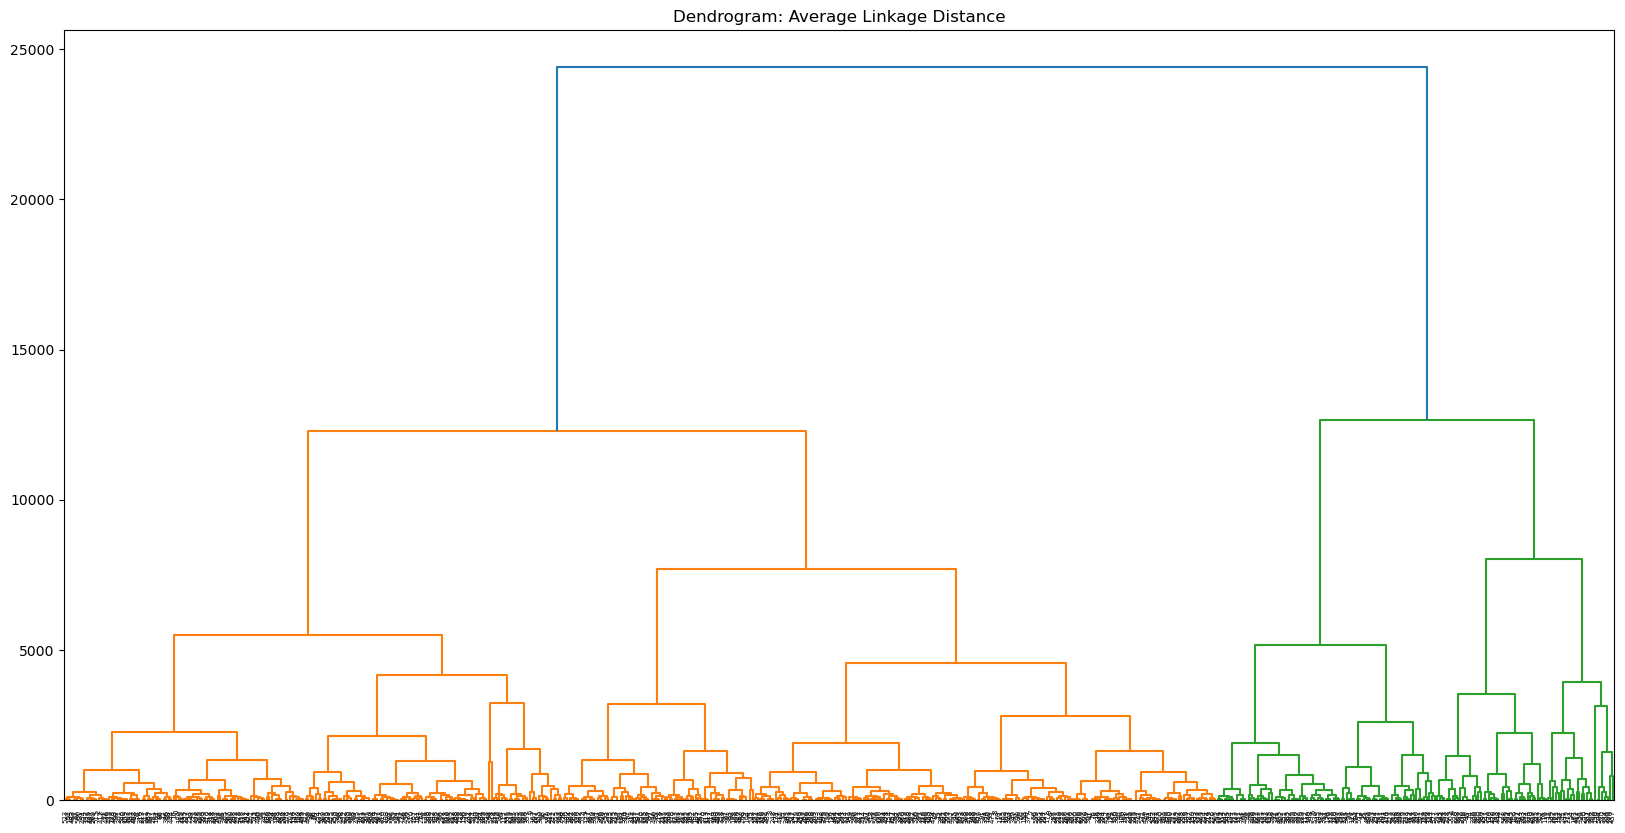

In [152]:
plt.figure(figsize=(20, 10))  
plt.title("Dendrogram: Average Linkage Distance")
dgclstr4 = hc.dendrogram(clstr4)
plt.show()

In [187]:
max(clstr4[:,2])

24414.358430469827

In [192]:
clstr4[-20:,2] #largest value associated with the final merger

array([ 2124.15594841,  2219.5162731 ,  2225.06837599,  2263.44742112,
        2609.5095087 ,  2790.22546328,  3130.15913455,  3209.99824314,
        3249.20933203,  3522.02652573,  3931.26520588,  4166.77677901,
        4560.48702404,  5168.47278976,  5493.18755005,  7707.8695592 ,
        8041.31196756, 12292.31598706, 12657.52206532, 24414.35843047])

In [225]:
# Identify cluster membership
maxdist4 = 12500
clusters4 = fcluster(clstr4, maxdist4, criterion='distance')
clusters4

array([1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 2, 1, 1, 3, 1,
       2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1,
       1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1,
       2, 1, 2, 1, 2, 3, 1, 1, 1, 2, 1, 3, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2,
       1, 2, 3, 1, 1, 2, 2, 3, 2, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 2, 3, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 3,
       2, 1, 1, 2, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 2, 1, 1, 3,
       1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 3,
       1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 2, 1, 1,
       1, 1, 1, 2, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1,

In [226]:
# Add the cluster id to the original datasetb
df24 = df2.copy()
df24['CLUSTER'] = clusters4.tolist()
df24

,age,sex,income,married,children,car,savings,checking,mortgage,pep,city,town,rural,suburban,CLUSTER
0,48,1,17546.00,0,1,0,0,0,0,1,1,0,0,0,1
1,40,0,30085.10,1,3,1,0,1,1,0,0,1,0,0,1
2,51,1,16575.40,1,0,1,1,1,0,0,1,0,0,0,1
3,23,1,20375.40,1,3,0,0,1,0,0,0,1,0,0,1
4,57,1,50576.30,1,0,0,1,0,0,0,0,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,61,1,47025.00,0,2,1,1,1,1,0,1,0,0,0,3
596,30,1,9672.25,1,0,1,1,1,0,0,1,0,0,0,1
597,31,1,15976.30,1,0,1,1,0,0,1,0,1,0,0,1
598,29,0,14711.80,1,0,0,1,0,1,0,1,0,0,0,1


In [227]:
# Get the averages of all the columns by cluster ID to try and identify cluster characteristics
# And review the cluster characteristics
df24Avg = df24.groupby('CLUSTER', as_index=False).mean()
df24Avg

,CLUSTER,age,sex,income,married,children,car,savings,checking,mortgage,pep,city,town,rural,suburban
0,1,37.513453,0.508969,21257.682354,0.659193,0.988789,0.482063,0.616592,0.744395,0.356502,0.417040,0.446188,0.311659,0.145740,0.096413
1,2,52.576471,0.447059,40000.804706,0.658824,1.047059,0.517647,0.823529,0.800000,0.317647,0.458824,0.494118,0.247059,0.152941,0.105882
2,3,61.405797,0.507246,52658.318841,0.666667,1.115942,0.536232,1.000000,0.797101,0.333333,0.710145,0.405797,0.188406,0.260870,0.144928


- 3 clear clusters can be seen from the dendrogram.
- Characteristics of each cluster:
- Cluster 0: Youngest among the clusters with an average age of 37.51 years, with lower average income (21257.68),indicating this group might consist of younger or entry-level professionals. Majority are married (65.9%) with 0.99 children per household. Lowest car ownership of all clusters (48.2%), lower average ownership of savings/checking accounts compared to other clusters but higher than Cluster 1 for checking accounts. Moderate mortgage ownership and relatively low personal equity plan (pep) products. Lastly, slightly more inclined to live in cities(44.61%) and towns(311.17%).
- Cluster 1: Middle-aged group with an average age of 52.58 years. Higher average income of (40000.80), which might indicate established professionals or individuals in their peak earning years, with higher marraige percetnage (65.9%) and average number of kids (1.05). Higher car ownership (51.8%), and higher savings/checking account ownership and similar mortgage ownership to Cluster 0. Moderately higher personal equity plan (pep) ownership. Lastly, more likely to live in cities, slightly less in towns, and least in rural areas compared to Cluster 0.
- Cluster 2: Oldest among the clusters with an average age (61.41), with highest average income of (52658.32), suggesting retirees or senior professionals. Slightly higher proportion of married individuals (66.7%), and highest average number of children (1.12) among all clusters. Highest among clusters at 53.6%. Financially, all individuals own savings accounts, very high checking account and mortgage ownership rates. Moderately high personal equity plan (pep) ownership. Mostly city or town dwellers but significantly more likely to live in rural areas(26.09%) and suburban areas (14.50%) compared to the other clusters.

### (v) Hierarchical Clustering: Ward linkage

In [153]:
clstr5 = hc.linkage(ndf2, method='ward', metric="euclidean")

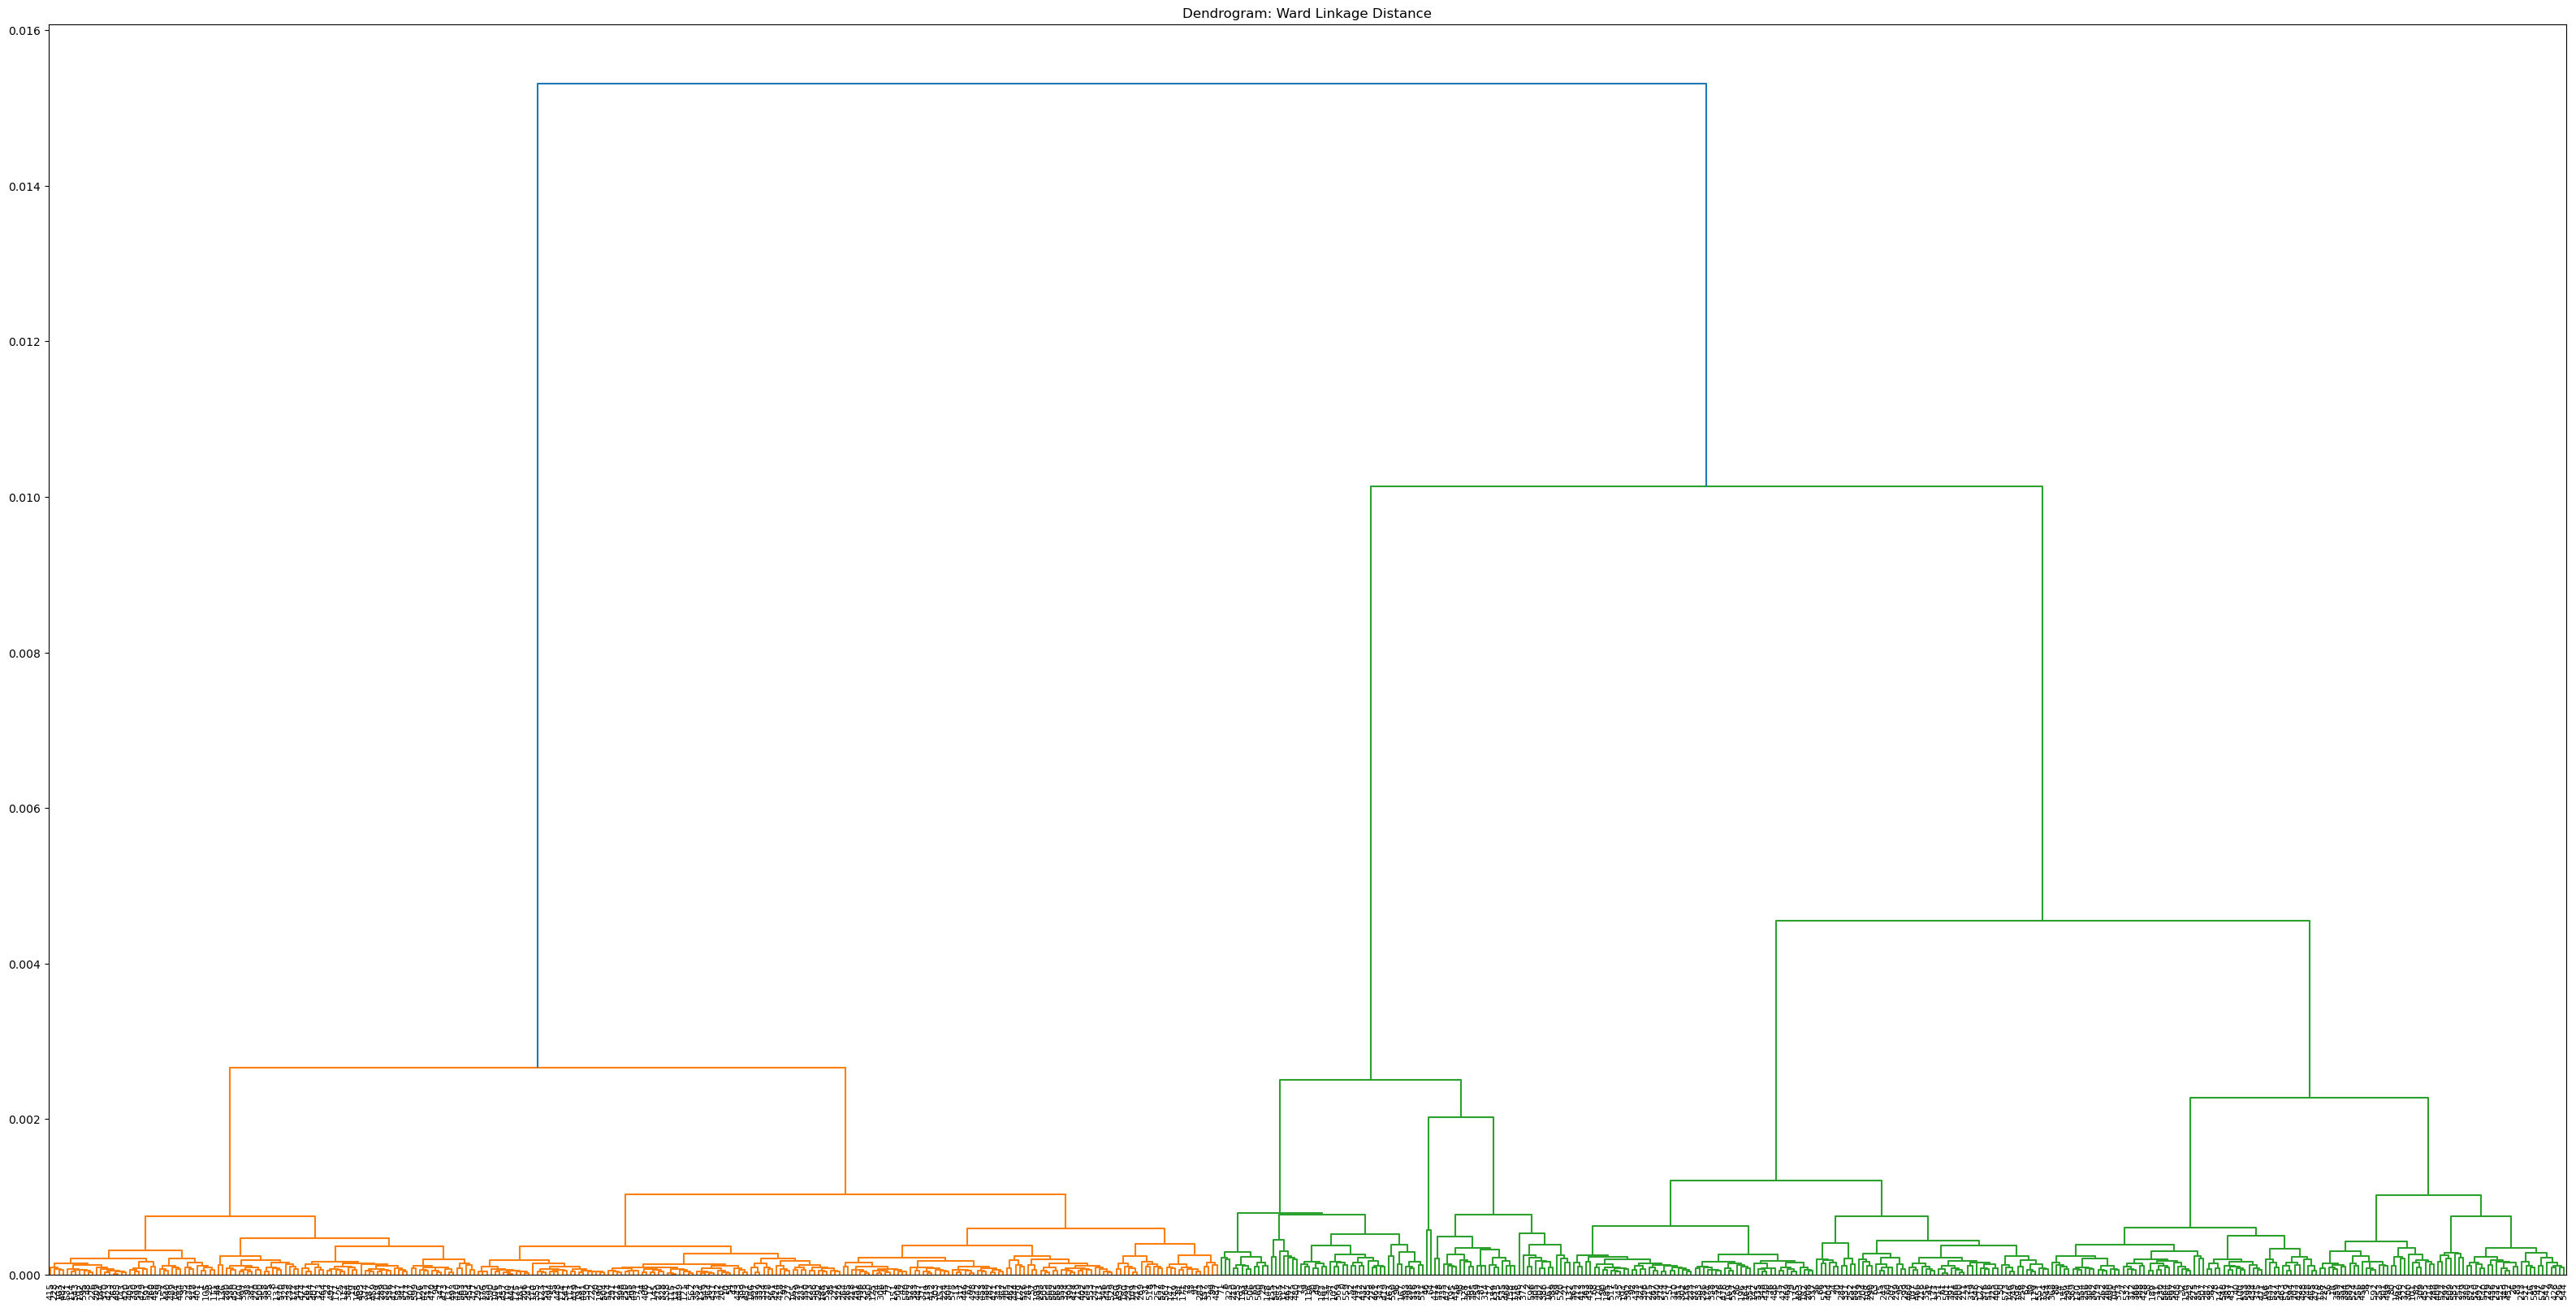

In [154]:
plt.figure(figsize=(40, 20))  
plt.title("Dendrogram: Ward Linkage Distance")
dgclstr5 = hc.dendrogram(clstr5, leaf_rotation=90., leaf_font_size=8.)
plt.show()

In [188]:
max(clstr5[:,2])

0.015311856829073676

In [193]:
clstr5[-20:,2] #largest value associated with the final merger

array([0.00057302, 0.00059644, 0.00060306, 0.00062113, 0.00075057,
       0.00075207, 0.00075402, 0.0007682 , 0.00077252, 0.00079277,
       0.00102296, 0.0010291 , 0.0012058 , 0.00202349, 0.00227987,
       0.00250094, 0.00265773, 0.00454716, 0.01013595, 0.01531186])

In [228]:
# Identify cluster membership
maxdist5 = 0.009
clusters5 = fcluster(clstr5, maxdist5, criterion='distance')
clusters5

array([2, 1, 2, 1, 1, 3, 2, 3, 1, 3, 1, 3, 2, 1, 3, 3, 3, 1, 3, 1, 1, 2,
       1, 3, 3, 1, 3, 3, 1, 2, 2, 1, 3, 1, 1, 1, 3, 2, 3, 2, 3, 3, 1, 1,
       1, 1, 2, 3, 1, 2, 3, 3, 2, 3, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 2, 2,
       3, 1, 3, 2, 3, 2, 1, 2, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 2, 1, 3, 2,
       3, 3, 3, 1, 3, 1, 1, 3, 2, 1, 2, 1, 3, 3, 2, 1, 3, 1, 1, 3, 3, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1, 2, 1, 3, 1,
       2, 3, 1, 3, 1, 1, 3, 1, 1, 3, 3, 1, 1, 1, 3, 1, 2, 1, 3, 1, 1, 1,
       3, 2, 3, 1, 2, 2, 1, 2, 3, 2, 3, 1, 3, 2, 1, 3, 1, 1, 1, 1, 3, 1,
       1, 1, 2, 3, 1, 1, 3, 2, 1, 3, 1, 1, 1, 3, 1, 2, 1, 2, 3, 2, 3, 1,
       3, 1, 3, 1, 2, 3, 3, 1, 1, 3, 3, 1, 2, 3, 3, 3, 3, 3, 3, 1, 1, 1,
       1, 1, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 2, 1, 1, 1, 3, 3, 1,
       3, 3, 3, 1, 2, 1, 3, 3, 1, 1, 3, 3, 3, 2, 3, 1, 3, 2, 1, 1, 3, 1,
       1, 1, 3, 3, 3, 1, 1, 1, 2, 1, 3, 3, 3, 1, 2, 1, 1, 1, 1, 1, 3, 2,
       3, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3, 3, 2, 3, 3,

In [229]:
# Add the cluster id to the original datasetb
df25 = df2.copy()
df25['CLUSTER'] = clusters5.tolist()
df25

,age,sex,income,married,children,car,savings,checking,mortgage,pep,city,town,rural,suburban,CLUSTER
0,48,1,17546.00,0,1,0,0,0,0,1,1,0,0,0,2
1,40,0,30085.10,1,3,1,0,1,1,0,0,1,0,0,1
2,51,1,16575.40,1,0,1,1,1,0,0,1,0,0,0,2
3,23,1,20375.40,1,3,0,0,1,0,0,0,1,0,0,1
4,57,1,50576.30,1,0,0,1,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,61,1,47025.00,0,2,1,1,1,1,0,1,0,0,0,1
596,30,1,9672.25,1,0,1,1,1,0,0,1,0,0,0,2
597,31,1,15976.30,1,0,1,1,0,0,1,0,1,0,0,3
598,29,0,14711.80,1,0,0,1,0,1,0,1,0,0,0,3


In [230]:
# Get the averages of all the columns by cluster ID to try and identify cluster characteristics
# And review the cluster characteristics
df25Avg = df25.groupby('CLUSTER', as_index=False).mean()
df25Avg

,CLUSTER,age,sex,income,married,children,car,savings,checking,mortgage,pep,city,town,rural,suburban
0,1,43.100358,0.480287,35450.250179,0.641577,1.064516,0.526882,0.770609,0.788530,0.351254,0.519713,0.451613,0.258065,0.193548,0.096774
1,2,43.333333,0.523810,15727.119524,0.630952,0.964286,0.392857,0.583333,0.702381,0.333333,0.369048,0.511905,0.261905,0.119048,0.107143
2,3,41.232068,0.514768,22374.349747,0.691983,0.966245,0.489451,0.632911,0.742616,0.350211,0.413502,0.421941,0.333333,0.135021,0.109705


- 3 clear clusters can be seen from the dendrogram.
- Characteristics of each cluster:
- Cluster 0: Middle-aged group with an average age 43.1 years old. Moderate average income of (35,450.25), suggesting middle-class individuals or families. A significant portion are married (64.2%) with slightly above one child(1.06) per household on average, indicating stable family units. More than half own a car (52.7%), highest car ownership of all 3 clusters. Highest ownership rates of savings/checking accounts, mortgage, and personal equity plan (pep) ownership. Mostly living in cities, with a fair distribution across town and highest rural dwelling percentage of all 3 clusters but lowest in suburban areas.
- Cluster 1: Average age of 43.33 years, which is similar to Cluster 0, with lower average income (15,727.12), likely indicating entry-level employees, part-time workers, or lower-income families. Slightly lower percentage of married than Cluster 0 at 63.1% and fewer children on average compared to other clusters, suggesting smaller families or single-parent families. Lower car ownership rate (39.3%), with lower ownership of savings/checking accounts, and mortgages, and the least number of individuals with pep products, which may reflect economic constraints. More likely to live in cities(51.20%), with the least likely to live in rural or suburban areas(11.90% and 10.71% respectively).
- Cluster 2: Slightly younger than Clusters 0 and 1, (avg 41.23 years old). Higher than Cluster 1 but lower than Cluster 0, with an average income 22,374.35, suggesting lower-middle-class individuals or families. The highest married percentage (69.2%), with similar number of children to other clusters. Nearly half(48.95%) own a car, and moderate ownership of savings/checking, and mortgage, with slightly less financial product ownership than Cluster 0 but more than Cluster 1. Evenly distributed across city, town, and rural areas with a slightly higher presence in rural areas compared to the other clusters, and least likely to live in suburban areas.

### 2-ii). Across all the linkage approaches tried, which one has worked best in this example (provide your reasoning)? What are some distinguishing characteristics of each cluster?

- Based on the dendrograms above, Ward linkage seems the best, as it has the most balanced and distinct clusters between different levels of hierarchy, so it is easier for us to identify distinct clusters within the dataset. Also, when comparing each cluster within each linkage approaches, clusters within Ward linkage have more homogeneity within themselves and more distinct from each other compared to other method. 
- Three clusters are identified by where this line cuts the dendrogram, and this can be clearly seen in the truncated hierarchical clustering dendrograms as below.

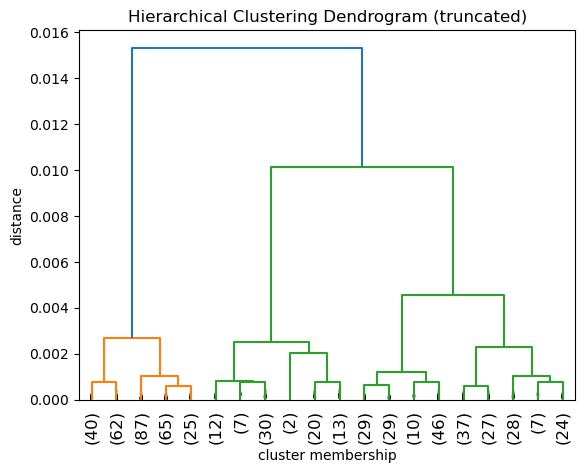

In [183]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('cluster membership')
plt.ylabel('distance')
hc.dendrogram(clstr5, truncate_mode='lastp', p=20, show_leaf_counts=True, leaf_rotation=90., leaf_font_size=12., show_contracted=True)
#plt.axhline(y=0.42, color='black', linestyle='--')
plt.show()

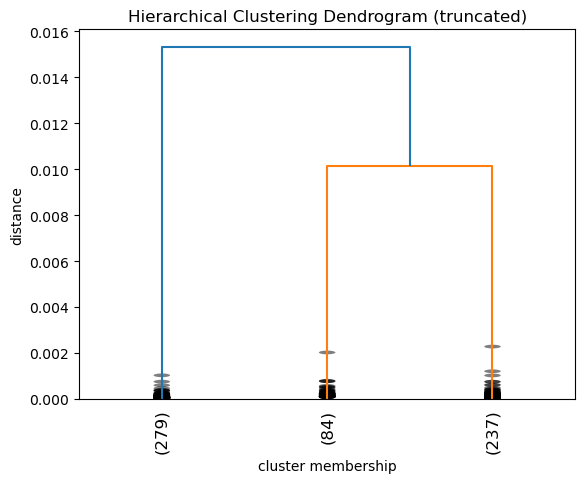

In [194]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('cluster membership')
plt.ylabel('distance')
hc.dendrogram(clstr5, truncate_mode='lastp', p=3, show_leaf_counts=True, leaf_rotation=90., leaf_font_size=12., show_contracted=True)
#plt.axhline(y=0.42, color='black', linestyle='--')
plt.show()

1. Centroid Linkage: Based on the dendrogram, the clusters seem to merge at lower level. The clusters seem balanced for 2 clusters, but the third cluster does not, and not as distinctly separated as some other linkage approaches.

2. Average Linkage: In the average linkage dendrogram, clusters form at various levels, so that we can see clear hierarchies. And as the smaller clusters form at the lower levels, we can see that they gradually merge into larger groups.

3. Complete Linkage: This dendrogram also shows a very distinct separation between clusters, just as from Average Linkage. Due to clear cluster formations at various levels, we can again see clear hierarchies.

4. Single Linkage: The single linkage dendrogram shows a very elongated structure. Many clusters are formed at very low distance levels, and hard to differentiate between clusters, which indicates a gradual similarity rather than distinct groupings.

5. Ward Linkage: Among all 5 linkage approaches, the Ward linkage dendrogram shows the clearest and the most balanced hierarchical structure. The clusters form in a more uniform manner, with clear distinctions at various levels. Accordingly, we see a clear hierarchy in the dendrogram. Also, the clusters are more evenly sized and well-defined, suggesting a good balance between within-cluster similarity and between-cluster dissimilarity.

### 3. Apply k-means clustering to the dataset. Try different values of k (4, 5, 6, 7, and 8 at least); make sure you include the number of clusters you decided to use with hierarchical clustering. Are clear clusters visible for any value of k? As before, how many clusters would you recommend, and why? What are some distinguishing characteristics of each cluster? How different are these results from those with hierarchical clustering? Which seems preferable in this case? Explain.

In [155]:
# Import k-means package
from sklearn.cluster import KMeans as km

### (i) K = 3

In [231]:
clstr11 = km(n_clusters=3, random_state=0) 
clstr11.fit(ndf2)

/Users/eunsungchoi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=0)

In [232]:
clusters11 = clstr11.labels_
clusters11

array([1, 2, 1, 2, 2, 2, 1, 1, 2, 0, 2, 0, 1, 2, 0, 0, 0, 2, 1, 2, 2, 1,
       2, 0, 0, 2, 0, 0, 2, 1, 1, 2, 0, 2, 2, 2, 0, 1, 1, 1, 0, 0, 2, 2,
       2, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 1, 1,
       0, 2, 2, 1, 0, 1, 2, 1, 2, 0, 0, 2, 0, 0, 0, 2, 1, 0, 1, 2, 0, 1,
       0, 0, 2, 2, 2, 2, 2, 0, 1, 2, 1, 2, 0, 1, 1, 2, 0, 2, 2, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 0, 2,
       1, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 2, 1, 2, 0, 2, 2, 2,
       0, 1, 0, 2, 1, 1, 2, 1, 1, 1, 0, 2, 0, 1, 2, 0, 2, 2, 2, 2, 0, 2,
       2, 2, 1, 0, 2, 2, 0, 1, 2, 2, 2, 2, 2, 0, 2, 1, 2, 1, 2, 1, 0, 2,
       0, 2, 0, 2, 1, 0, 0, 2, 2, 0, 0, 2, 1, 0, 2, 0, 1, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 2, 1, 2, 2, 2, 0, 1, 2,
       0, 0, 0, 2, 1, 2, 0, 0, 2, 2, 0, 1, 0, 1, 0, 2, 0, 1, 2, 2, 0, 2,
       2, 2, 0, 0, 0, 2, 2, 2, 1, 2, 2, 0, 0, 2, 1, 2, 2, 2, 2, 2, 0, 1,
       0, 0, 1, 2, 0, 2, 2, 2, 0, 2, 0, 0, 1, 0, 1,

In [233]:
ndf211 = ndf2.copy()
ndf211['CLUSTER'] = clusters11.tolist()
ndf211

,age,sex,income,married,children,car,savings,checking,mortgage,pep,city,town,rural,suburban,CLUSTER
0,0.002736,0.000057,0.999996,0.000000,0.000057,0.000000,0.000000,0.000000,0.000000,0.000057,0.000057,0.000000,0.00000,0.0,1
1,0.001330,0.000000,0.999999,0.000033,0.000100,0.000033,0.000000,0.000033,0.000033,0.000000,0.000000,0.000033,0.00000,0.0,2
2,0.003077,0.000060,0.999995,0.000060,0.000000,0.000060,0.000060,0.000060,0.000000,0.000000,0.000060,0.000000,0.00000,0.0,1
3,0.001129,0.000049,0.999999,0.000049,0.000147,0.000000,0.000000,0.000049,0.000000,0.000000,0.000000,0.000049,0.00000,0.0,2
4,0.001127,0.000020,0.999999,0.000020,0.000000,0.000000,0.000020,0.000000,0.000000,0.000000,0.000000,0.000000,0.00002,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.001297,0.000021,0.999999,0.000000,0.000043,0.000021,0.000021,0.000021,0.000021,0.000000,0.000021,0.000000,0.00000,0.0,2
596,0.003102,0.000103,0.999995,0.000103,0.000000,0.000103,0.000103,0.000103,0.000000,0.000000,0.000103,0.000000,0.00000,0.0,1
597,0.001940,0.000063,0.999998,0.000063,0.000000,0.000063,0.000063,0.000000,0.000000,0.000063,0.000000,0.000063,0.00000,0.0,0
598,0.001971,0.000000,0.999998,0.000068,0.000000,0.000000,0.000068,0.000000,0.000068,0.000000,0.000068,0.000000,0.00000,0.0,0


In [234]:
# Check cluster sizes
ndf211['CLUSTER'].value_counts()

2    307
0    189
1    104
Name: CLUSTER, dtype: int64

In [235]:
# Get averages by cluster to see how the clusters are different
ndf211avg = ndf211.groupby('CLUSTER', as_index=False).mean()
ndf211avg

,CLUSTER,age,sex,income,married,children,car,savings,checking,mortgage,pep,city,town,rural,suburban
0,0,0.001880,0.000024,0.999998,0.000033,0.000055,0.000025,0.000032,0.000039,0.000020,0.000020,0.000024,0.000016,0.000007,0.000005
1,1,0.002701,0.000039,0.999996,0.000046,0.000066,0.000030,0.000043,0.000053,0.000023,0.000024,0.000037,0.000020,0.000008,0.000007
2,2,0.001257,0.000016,0.999999,0.000023,0.000034,0.000017,0.000024,0.000026,0.000012,0.000016,0.000015,0.000009,0.000006,0.000003


- Distinguishing characteristics of each cluster:
- Cluster 0: middle aged clusters compared to two other clusters, has the highest average income compared to the other clusters (0.999998). Average presence in terms of married, children, car, savings/checking, mortgage, personal equity plan (pep) in this cluster. Lastly, most of the members of this clusters are urban-dwells livign in either city or town.

- Cluster 1: Oldest among all 3 clusters, with more females than Cluster 0. with slightly lower avg income than Cluster 0 (0.999996). Similar to Cluster 0 but with higher values in marriage percentage and avg number of children suggesting this group may contain more married individuals or those with children. Most of the cluster members are city dwellers, but slightly higher preference for town and rural areas compared to Cluster 0, suggesting a different living environment preference.

- Cluster 2: Lowest average age (0.001257) compared to the other two clusters, with more male in the cluster. Highest income(0.999999), indicating this cluster includes members with the highest relative income levels. On the other hand these individuals are less likely to be married, have children, or own a car. The lower savings and mortgage averages could indicate younger individuals or those with different financial priorities. Lastly, lower values across city, town, rural, and suburban, with a slightly higher preference for city and town.

### (ii) K = 4

In [157]:
clstr6 = km(n_clusters=4, random_state=0) 
clstr6.fit(ndf2)

/Users/eunsungchoi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=4, random_state=0)

In [158]:
clusters6 = clstr6.labels_
clusters6

array([0, 1, 0, 1, 1, 2, 0, 3, 2, 3, 1, 3, 0, 1, 2, 2, 3, 1, 3, 1, 1, 0,
       1, 2, 2, 1, 3, 3, 1, 0, 0, 1, 3, 1, 1, 1, 2, 0, 3, 0, 3, 2, 1, 1,
       2, 1, 0, 3, 1, 0, 2, 2, 0, 2, 1, 1, 3, 1, 3, 1, 2, 2, 2, 2, 0, 3,
       2, 1, 2, 0, 2, 0, 1, 0, 1, 2, 2, 1, 3, 2, 3, 1, 3, 3, 0, 1, 2, 0,
       2, 2, 2, 1, 2, 2, 2, 2, 0, 1, 0, 1, 3, 3, 0, 1, 2, 1, 1, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 3, 1, 2, 1, 2, 1, 1, 1, 2, 1, 0, 1, 2, 2,
       0, 2, 1, 2, 2, 2, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 3, 1, 2, 1, 1, 1,
       2, 3, 2, 1, 0, 0, 1, 0, 3, 0, 2, 1, 3, 0, 1, 2, 1, 1, 2, 1, 2, 1,
       1, 1, 0, 2, 1, 1, 2, 0, 1, 2, 1, 1, 1, 2, 1, 0, 1, 0, 2, 0, 2, 1,
       2, 1, 2, 1, 0, 3, 2, 1, 1, 2, 2, 1, 0, 2, 2, 3, 3, 2, 2, 1, 1, 1,
       1, 1, 1, 2, 1, 2, 1, 3, 1, 3, 3, 1, 3, 1, 1, 0, 1, 1, 2, 2, 3, 1,
       3, 2, 2, 1, 0, 1, 3, 2, 1, 1, 2, 3, 3, 0, 2, 1, 2, 0, 1, 1, 2, 1,
       1, 1, 2, 2, 2, 1, 1, 1, 0, 1, 2, 3, 2, 1, 0, 1, 2, 1, 1, 1, 2, 0,
       2, 3, 3, 1, 2, 1, 1, 1, 2, 1, 3, 3, 0, 2, 3,

In [159]:
ndf26 = ndf2.copy()
ndf26['CLUSTER'] = clusters6.tolist()
ndf26

,age,sex,income,married,children,car,savings,checking,mortgage,pep,city,town,rural,suburban,CLUSTER
0,0.002736,0.000057,0.999996,0.000000,0.000057,0.000000,0.000000,0.000000,0.000000,0.000057,0.000057,0.000000,0.00000,0.0,0
1,0.001330,0.000000,0.999999,0.000033,0.000100,0.000033,0.000000,0.000033,0.000033,0.000000,0.000000,0.000033,0.00000,0.0,1
2,0.003077,0.000060,0.999995,0.000060,0.000000,0.000060,0.000060,0.000060,0.000000,0.000000,0.000060,0.000000,0.00000,0.0,0
3,0.001129,0.000049,0.999999,0.000049,0.000147,0.000000,0.000000,0.000049,0.000000,0.000000,0.000000,0.000049,0.00000,0.0,1
4,0.001127,0.000020,0.999999,0.000020,0.000000,0.000000,0.000020,0.000000,0.000000,0.000000,0.000000,0.000000,0.00002,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.001297,0.000021,0.999999,0.000000,0.000043,0.000021,0.000021,0.000021,0.000021,0.000000,0.000021,0.000000,0.00000,0.0,1
596,0.003102,0.000103,0.999995,0.000103,0.000000,0.000103,0.000103,0.000103,0.000000,0.000000,0.000103,0.000000,0.00000,0.0,0
597,0.001940,0.000063,0.999998,0.000063,0.000000,0.000063,0.000063,0.000000,0.000000,0.000063,0.000000,0.000063,0.00000,0.0,3
598,0.001971,0.000000,0.999998,0.000068,0.000000,0.000000,0.000068,0.000000,0.000068,0.000000,0.000068,0.000000,0.00000,0.0,3


In [160]:
# Check cluster sizes
ndf26['CLUSTER'].value_counts()

1    250
2    163
3    108
0     79
Name: CLUSTER, dtype: int64

In [162]:
# Get averages by cluster to see how the clusters are different
ndf26avg = ndf26.groupby('CLUSTER', as_index=False).mean()
ndf26avg

,CLUSTER,age,sex,income,married,children,car,savings,checking,mortgage,pep,city,town,rural,suburban
0,0,0.002809,0.000038,0.999996,0.000041,0.000067,0.000029,0.000039,0.000053,0.000026,0.000025,0.000039,0.000021,0.000008,0.000005
1,1,0.001203,0.000015,0.999999,0.000021,0.000033,0.000016,0.000023,0.000025,0.000011,0.000017,0.000014,0.000009,0.000006,0.000003
2,2,0.001649,0.000022,0.999999,0.000031,0.000043,0.000020,0.000029,0.000035,0.000016,0.000015,0.000022,0.000012,0.000006,0.000005
3,3,0.002134,0.000031,0.999998,0.000041,0.000066,0.000031,0.000041,0.000045,0.000021,0.000023,0.000025,0.000019,0.000009,0.000008


- Distinguishing characteristics of each cluster:
- Cluster 0: Oldest cluster with highest average age (0.002809) with more female and highest marriage percentage compared to other clusters as cluster0 primarily consists of individuals who are married (0.000041).car ownership, savings, checking, mortgage, PEP, and residential area have less distinctive impacts on defining this cluster. High car, savings/checking account, mortgage or pep ownsership, and most of them are utban dwellers with highest dwelling rate in city (0.000039) and town(0.000021).

- Cluster 1: Youngest cluster of all with more males. Lowest marriage rate of all as well, suggesting younger and single male dominant cluster. Car ownership, savings/checking account, mortgage or pep ownerships are also low compared to other clusters as well. Lastly, tiny inclination towards city and town living over rural and suburban, but these are still not major distinguishing factors of this cluster.

- Cluster 2: Second youngest cluster, with higher marriage rate compared to Cluster 1 but lower than other two clusters. Minor increase in the values for having children and car ownership, compared to Cluster 1. Low values across all residential areas, but still slightly higher preference in city and town.

- Cluster 3: Second oldest cluster, with more females in the cluster. Highest marriage percentage compared to other clusters. Highest values for avg number of children, car ownership, savings/checking/mortage or pep, suggesting the stability of financial income. Despite the low values, there’s a slight increase in the probabilities for different living areas, especially suburban, compared to other clusters.

### (iii) K = 5

In [163]:
clstr7 = km(n_clusters=5, random_state=0) 
clstr7.fit(ndf2)

/Users/eunsungchoi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=5, random_state=0)

In [164]:
clusters7 = clstr7.labels_
clusters7

array([1, 0, 1, 3, 3, 0, 2, 2, 0, 2, 3, 4, 1, 3, 4, 4, 2, 3, 2, 0, 3, 1,
       0, 4, 4, 0, 2, 4, 0, 2, 1, 3, 4, 3, 3, 0, 4, 1, 2, 1, 2, 4, 3, 3,
       0, 3, 1, 2, 0, 1, 4, 0, 1, 0, 3, 3, 2, 3, 4, 0, 4, 4, 4, 4, 1, 2,
       4, 3, 0, 1, 4, 1, 3, 2, 3, 4, 4, 3, 4, 4, 2, 3, 2, 2, 1, 3, 0, 1,
       4, 4, 0, 3, 0, 0, 0, 4, 1, 3, 1, 3, 4, 2, 1, 3, 4, 0, 3, 4, 4, 3,
       3, 0, 0, 3, 3, 3, 1, 1, 2, 0, 0, 3, 4, 3, 3, 3, 0, 3, 1, 3, 4, 0,
       1, 4, 3, 4, 0, 0, 0, 3, 0, 2, 0, 0, 0, 3, 4, 3, 2, 3, 4, 3, 3, 0,
       4, 2, 4, 3, 1, 1, 3, 1, 2, 1, 0, 3, 2, 1, 0, 4, 3, 3, 0, 3, 0, 3,
       3, 0, 1, 4, 3, 3, 4, 1, 3, 0, 3, 0, 3, 4, 3, 1, 0, 2, 0, 1, 0, 3,
       4, 3, 4, 3, 1, 4, 4, 3, 3, 4, 4, 3, 2, 4, 0, 2, 2, 0, 4, 3, 3, 3,
       0, 3, 3, 0, 3, 4, 0, 2, 0, 2, 4, 3, 2, 3, 0, 1, 3, 3, 0, 4, 2, 3,
       4, 4, 4, 3, 1, 3, 4, 4, 3, 3, 0, 2, 4, 1, 4, 3, 4, 1, 3, 0, 4, 3,
       3, 3, 4, 0, 4, 3, 3, 3, 1, 3, 0, 4, 0, 3, 1, 3, 0, 3, 3, 3, 0, 1,
       0, 2, 2, 0, 4, 3, 3, 3, 4, 3, 2, 2, 1, 4, 2,

In [165]:
ndf27 = ndf2.copy()
ndf27['CLUSTER'] = clusters7.tolist()
ndf27

,age,sex,income,married,children,car,savings,checking,mortgage,pep,city,town,rural,suburban,CLUSTER
0,0.002736,0.000057,0.999996,0.000000,0.000057,0.000000,0.000000,0.000000,0.000000,0.000057,0.000057,0.000000,0.00000,0.0,1
1,0.001330,0.000000,0.999999,0.000033,0.000100,0.000033,0.000000,0.000033,0.000033,0.000000,0.000000,0.000033,0.00000,0.0,0
2,0.003077,0.000060,0.999995,0.000060,0.000000,0.000060,0.000060,0.000060,0.000000,0.000000,0.000060,0.000000,0.00000,0.0,1
3,0.001129,0.000049,0.999999,0.000049,0.000147,0.000000,0.000000,0.000049,0.000000,0.000000,0.000000,0.000049,0.00000,0.0,3
4,0.001127,0.000020,0.999999,0.000020,0.000000,0.000000,0.000020,0.000000,0.000000,0.000000,0.000000,0.000000,0.00002,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.001297,0.000021,0.999999,0.000000,0.000043,0.000021,0.000021,0.000021,0.000021,0.000000,0.000021,0.000000,0.00000,0.0,3
596,0.003102,0.000103,0.999995,0.000103,0.000000,0.000103,0.000103,0.000103,0.000000,0.000000,0.000103,0.000000,0.00000,0.0,1
597,0.001940,0.000063,0.999998,0.000063,0.000000,0.000063,0.000063,0.000000,0.000000,0.000063,0.000000,0.000063,0.00000,0.0,4
598,0.001971,0.000000,0.999998,0.000068,0.000000,0.000000,0.000068,0.000000,0.000068,0.000000,0.000068,0.000000,0.00000,0.0,4


In [166]:
# Check cluster sizes
ndf27['CLUSTER'].value_counts()

3    191
0    135
4    128
2     74
1     72
Name: CLUSTER, dtype: int64

In [167]:
# Get averages by cluster to see how the clusters are different
ndf27avg = ndf27.groupby('CLUSTER', as_index=False).mean()
ndf27avg

,CLUSTER,age,sex,income,married,children,car,savings,checking,mortgage,pep,city,town,rural,suburban
0,0,0.001451,0.000019,0.999999,0.000027,0.000041,0.000018,0.000027,0.000030,0.000015,0.000016,0.000018,0.000010,0.000007,0.000004
1,1,0.002838,0.000039,0.999996,0.000043,0.000072,0.000031,0.000042,0.000053,0.000026,0.000022,0.000041,0.000022,0.000007,0.000005
2,2,0.002263,0.000032,0.999997,0.000043,0.000065,0.000028,0.000042,0.000043,0.000019,0.000026,0.000025,0.000021,0.000009,0.000009
3,3,0.001155,0.000015,0.999999,0.000021,0.000031,0.000016,0.000022,0.000025,0.000011,0.000016,0.000014,0.000008,0.000005,0.000003
4,4,0.001827,0.000023,0.999998,0.000032,0.000049,0.000026,0.000032,0.000040,0.000018,0.000019,0.000024,0.000015,0.000007,0.000004


- Distinguishing characteristics of each cluster:
- Cluster 0: Second youngest cluster of all and second youngest marraige rate with low avg number of children. Ownership in cars or finacial stfufs are also low. Lastly, mostly city dwellers but minimal distinction based on residential area.

- Cluster 1: Oldest cluster of all with more female. Highest marriage rate with higest avg number of children. Also financially stable, supported by car, savings/checking accounts, mortgage, pep ownership. Mostly city dwellers and in town.

- Cluster 2: Second oldest cluster, with highest marriage rate and avg number of children. This cluster shows slightly higher values for car, savings/checking accounts, mortgage, pep ownerships. Mostly city dwellers, but with mixed residential preferences.

- Cluster 3: Youngest cluster with lowest marriage rate and avg number of children. However, lower values for all other attributes, such as cars or financial attributes. Very low distinction based on residential area.

- Cluster 4: Young cluster but with average marriage rate. Moderate values for car, savings/checking accounts, mortgage or pep ownership. Mostly city dwellers but still balanced residential preferences.

### (iv) K = 6

In [168]:
clstr8 = km(n_clusters=6, random_state=0) 
clstr8.fit(ndf2)

/Users/eunsungchoi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=6, random_state=0)

In [169]:
clusters8 = clstr8.labels_
clusters8

array([4, 0, 4, 2, 2, 0, 1, 1, 0, 1, 2, 3, 4, 2, 3, 3, 1, 2, 1, 0, 2, 4,
       0, 3, 3, 0, 1, 3, 0, 1, 4, 2, 3, 2, 2, 0, 3, 4, 1, 4, 3, 3, 2, 2,
       0, 2, 5, 1, 0, 4, 3, 0, 4, 0, 2, 2, 1, 2, 3, 0, 3, 3, 3, 3, 5, 1,
       3, 2, 0, 4, 3, 4, 2, 1, 2, 3, 3, 2, 3, 3, 1, 2, 1, 1, 4, 2, 0, 4,
       3, 3, 0, 2, 0, 0, 0, 3, 4, 2, 4, 2, 3, 1, 4, 2, 3, 0, 2, 3, 3, 2,
       2, 0, 0, 2, 2, 2, 4, 4, 1, 0, 0, 2, 3, 2, 2, 2, 0, 2, 4, 2, 3, 0,
       4, 3, 2, 3, 0, 0, 0, 2, 0, 1, 0, 2, 0, 2, 3, 2, 1, 2, 3, 2, 2, 0,
       3, 1, 3, 2, 4, 4, 2, 4, 1, 4, 0, 2, 1, 4, 0, 0, 2, 2, 0, 2, 0, 2,
       2, 0, 4, 3, 2, 2, 3, 4, 2, 0, 2, 0, 2, 3, 2, 4, 2, 1, 0, 4, 0, 2,
       3, 2, 3, 2, 4, 3, 3, 2, 2, 3, 3, 2, 1, 3, 0, 1, 1, 0, 3, 2, 2, 2,
       0, 2, 2, 0, 2, 3, 0, 1, 0, 1, 3, 2, 1, 2, 0, 4, 2, 2, 0, 3, 1, 2,
       3, 3, 3, 2, 4, 2, 3, 3, 2, 2, 0, 1, 3, 4, 3, 2, 3, 4, 2, 0, 3, 2,
       2, 2, 3, 0, 3, 2, 2, 2, 4, 2, 0, 3, 0, 2, 4, 2, 0, 2, 2, 2, 0, 4,
       0, 3, 1, 0, 3, 2, 2, 2, 3, 2, 1, 1, 4, 3, 1,

In [170]:
ndf28 = ndf2.copy()
ndf28['CLUSTER'] = clusters8.tolist()
ndf28

,age,sex,income,married,children,car,savings,checking,mortgage,pep,city,town,rural,suburban,CLUSTER
0,0.002736,0.000057,0.999996,0.000000,0.000057,0.000000,0.000000,0.000000,0.000000,0.000057,0.000057,0.000000,0.00000,0.0,4
1,0.001330,0.000000,0.999999,0.000033,0.000100,0.000033,0.000000,0.000033,0.000033,0.000000,0.000000,0.000033,0.00000,0.0,0
2,0.003077,0.000060,0.999995,0.000060,0.000000,0.000060,0.000060,0.000060,0.000000,0.000000,0.000060,0.000000,0.00000,0.0,4
3,0.001129,0.000049,0.999999,0.000049,0.000147,0.000000,0.000000,0.000049,0.000000,0.000000,0.000000,0.000049,0.00000,0.0,2
4,0.001127,0.000020,0.999999,0.000020,0.000000,0.000000,0.000020,0.000000,0.000000,0.000000,0.000000,0.000000,0.00002,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.001297,0.000021,0.999999,0.000000,0.000043,0.000021,0.000021,0.000021,0.000021,0.000000,0.000021,0.000000,0.00000,0.0,2
596,0.003102,0.000103,0.999995,0.000103,0.000000,0.000103,0.000103,0.000103,0.000000,0.000000,0.000103,0.000000,0.00000,0.0,4
597,0.001940,0.000063,0.999998,0.000063,0.000000,0.000063,0.000063,0.000000,0.000000,0.000063,0.000000,0.000063,0.00000,0.0,3
598,0.001971,0.000000,0.999998,0.000068,0.000000,0.000000,0.000068,0.000000,0.000068,0.000000,0.000068,0.000000,0.00000,0.0,3


In [171]:
# Check cluster sizes
ndf28['CLUSTER'].value_counts()

2    194
0    136
3    127
4     71
1     70
5      2
Name: CLUSTER, dtype: int64

In [172]:
# Get averages by cluster to see how the clusters are different
ndf28avg = ndf28.groupby('CLUSTER', as_index=False).mean()
ndf28avg

,CLUSTER,age,sex,income,married,children,car,savings,checking,mortgage,pep,city,town,rural,suburban
0,0,0.001460,0.000019,0.999999,0.000027,0.000041,0.000018,0.000026,0.000030,0.000015,0.000016,0.000018,0.000010,0.000007,0.000004
1,1,0.002268,0.000033,0.999997,0.000043,0.000066,0.000029,0.000045,0.000044,0.000019,0.000027,0.000024,0.000022,0.000010,0.000009
2,2,0.001157,0.000015,0.999999,0.000021,0.000030,0.000016,0.000022,0.000025,0.000011,0.000016,0.000013,0.000008,0.000005,0.000003
3,3,0.001838,0.000023,0.999998,0.000033,0.000050,0.000026,0.000031,0.000041,0.000018,0.000018,0.000025,0.000015,0.000007,0.000004
4,4,0.002802,0.000039,0.999996,0.000044,0.000072,0.000027,0.000038,0.000050,0.000024,0.000022,0.000041,0.000019,0.000007,0.000005
5,5,0.003976,0.000038,0.999992,0.000000,0.000038,0.000137,0.000137,0.000137,0.000100,0.000038,0.000038,0.000100,0.000000,0.000000


- Distinguishing characteristics of each cluster:
- Cluster 0: Second youngest cluster with more male. Low values for income, children, car ownership, savings/checking accounts, mortgages, and personal equity plans (PEP). Mostly city dwellers but minimal distinction based on residential area.

- Cluster 1: Older cluster with more female. Second highest marriage rate and avg number of children. Second higheest values in car, savings/checking, pep ownership, indicating financial stability. Slightly higher values for living in a city or town, though these differences are marginal.

- Cluster 2: Youngest cluster with lowest marriage rate, except cluster 5. Low values across children or financial attributes. Lastly, very low distinction based on residential area.

- Cluster 3: Young cluster with high marriage rate. Moderate values for children, car ownership, and financial attributes. Indicates a slightly more balanced distribution across different living areas but still with low overall values.

- Cluster 4: Second oldest cluster with more female, with highest marriage rate and avg number of children. Car, savings/checking, mortgage or pep also high. Slight inclination towards town and suburban living.

- Cluster 5: Oldest cluster with more female and the lowest marriage rate (0). Distinct financial characteristics with much higher values in cars, savings/checking, and mortgage, suggesting individuals in this cluster might have substantial financial engagements or assets. Lastly, living either in city or town which shows significnat prefernece over urban.

### (v) K = 7

In [173]:
clstr9 = km(n_clusters=7, random_state=0) 
clstr9.fit(ndf2)

/Users/eunsungchoi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=7, random_state=0)

In [174]:
clusters9 = clstr9.labels_
clusters9

array([1, 4, 1, 0, 0, 4, 3, 3, 4, 3, 0, 2, 1, 0, 2, 5, 2, 0, 3, 4, 0, 1,
       4, 5, 5, 4, 3, 2, 4, 3, 1, 0, 2, 0, 0, 4, 5, 1, 3, 1, 2, 5, 0, 0,
       4, 0, 6, 3, 4, 1, 5, 4, 1, 5, 0, 0, 3, 0, 2, 4, 5, 5, 5, 5, 6, 3,
       5, 0, 4, 1, 5, 1, 0, 3, 0, 5, 5, 0, 2, 5, 3, 0, 3, 2, 1, 0, 5, 1,
       2, 5, 4, 0, 4, 4, 4, 5, 1, 0, 1, 0, 2, 3, 1, 4, 2, 4, 0, 5, 5, 0,
       0, 4, 4, 0, 4, 0, 1, 1, 3, 4, 5, 0, 5, 0, 0, 0, 4, 0, 1, 0, 2, 4,
       1, 5, 0, 5, 4, 4, 4, 0, 4, 2, 5, 4, 4, 0, 5, 0, 3, 0, 2, 0, 0, 4,
       5, 3, 2, 0, 1, 1, 0, 1, 3, 1, 5, 0, 2, 1, 4, 5, 0, 0, 4, 0, 5, 0,
       0, 4, 1, 5, 0, 0, 5, 1, 4, 4, 0, 4, 0, 2, 0, 1, 4, 3, 4, 1, 5, 0,
       5, 0, 5, 0, 1, 2, 5, 0, 0, 5, 5, 4, 3, 5, 4, 2, 3, 4, 5, 0, 0, 0,
       4, 0, 0, 4, 0, 5, 4, 3, 4, 3, 2, 0, 3, 0, 4, 1, 0, 0, 4, 5, 3, 0,
       2, 5, 5, 0, 1, 0, 2, 5, 0, 0, 5, 3, 2, 3, 2, 0, 5, 1, 4, 4, 2, 4,
       0, 0, 5, 5, 5, 0, 0, 0, 1, 0, 5, 2, 5, 0, 1, 0, 4, 0, 0, 0, 5, 1,
       5, 2, 3, 4, 5, 0, 0, 0, 2, 0, 3, 2, 1, 5, 3,

In [175]:
ndf29 = ndf2.copy()
ndf29['CLUSTER'] = clusters9.tolist()
ndf29

,age,sex,income,married,children,car,savings,checking,mortgage,pep,city,town,rural,suburban,CLUSTER
0,0.002736,0.000057,0.999996,0.000000,0.000057,0.000000,0.000000,0.000000,0.000000,0.000057,0.000057,0.000000,0.00000,0.0,1
1,0.001330,0.000000,0.999999,0.000033,0.000100,0.000033,0.000000,0.000033,0.000033,0.000000,0.000000,0.000033,0.00000,0.0,4
2,0.003077,0.000060,0.999995,0.000060,0.000000,0.000060,0.000060,0.000060,0.000000,0.000000,0.000060,0.000000,0.00000,0.0,1
3,0.001129,0.000049,0.999999,0.000049,0.000147,0.000000,0.000000,0.000049,0.000000,0.000000,0.000000,0.000049,0.00000,0.0,0
4,0.001127,0.000020,0.999999,0.000020,0.000000,0.000000,0.000020,0.000000,0.000000,0.000000,0.000000,0.000000,0.00002,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.001297,0.000021,0.999999,0.000000,0.000043,0.000021,0.000021,0.000021,0.000021,0.000000,0.000021,0.000000,0.00000,0.0,4
596,0.003102,0.000103,0.999995,0.000103,0.000000,0.000103,0.000103,0.000103,0.000000,0.000000,0.000103,0.000000,0.00000,0.0,1
597,0.001940,0.000063,0.999998,0.000063,0.000000,0.000063,0.000063,0.000000,0.000000,0.000063,0.000000,0.000063,0.00000,0.0,2
598,0.001971,0.000000,0.999998,0.000068,0.000000,0.000000,0.000068,0.000000,0.000068,0.000000,0.000068,0.000000,0.00000,0.0,2


In [176]:
# Check cluster sizes
ndf29['CLUSTER'].value_counts()

0    179
4    122
5     94
2     77
1     69
3     57
6      2
Name: CLUSTER, dtype: int64

In [177]:
# Get averages by cluster to see how the clusters are different
ndf29avg = ndf29.groupby('CLUSTER', as_index=False).mean()
ndf29avg

,CLUSTER,age,sex,income,married,children,car,savings,checking,mortgage,pep,city,town,rural,suburban
0,0,0.001145,0.000015,0.999999,0.000021,0.000032,0.000015,0.000021,0.000025,0.000010,0.000016,0.000013,0.000009,0.000006,0.000003
1,1,0.002809,0.000039,0.999996,0.000045,0.000074,0.000028,0.000040,0.000051,0.000025,0.000021,0.000041,0.000020,0.000007,0.000006
2,2,0.001971,0.000025,0.999998,0.000038,0.000065,0.000028,0.000034,0.000044,0.000023,0.000020,0.000021,0.000020,0.000010,0.000006
3,3,0.002323,0.000035,0.999997,0.000042,0.000050,0.000029,0.000042,0.000043,0.000018,0.000029,0.000028,0.000017,0.000008,0.000008
4,4,0.001406,0.000017,0.999999,0.000024,0.000037,0.000019,0.000026,0.000028,0.000013,0.000016,0.000017,0.000009,0.000007,0.000004
5,5,0.001697,0.000023,0.999999,0.000031,0.000048,0.000021,0.000030,0.000037,0.000017,0.000017,0.000026,0.000012,0.000005,0.000004
6,6,0.003976,0.000038,0.999992,0.000000,0.000038,0.000137,0.000137,0.000137,0.000100,0.000038,0.000038,0.000100,0.000000,0.000000


- Distinguishing characteristics of each cluster:
- Cluster 0: Youngest cluster, with second lowest marriage rate. Low values for income, children, car ownership, savings, checking accounts, mortgages, and personal equity plans (PEP), and very low distinction based on residential area.

- Cluster 1: Second oldest cluster with more male, and highest marriage rate with higher avg number of children. Car, savigns/checking accounts or mortgage, pep also high. Mostly city dwellers but slight inclination towards town and rural living.

- Cluster 2: High marriage rate, and moderate values for age, children, and car ownership. Lastly, balanced residential preference, which shows a slightly more balanced distribution across different living areas.

- Cluster 3: Highest marriage rate, and higher values for age and car ownership. Mixed residential preferences, which indicates a balanced distribution across different living areas with a slight inclination towards town and rural settings.

- Cluster 4: Second youngest cluster with lower marriage rate compared to other clusters. Low to moderate values for all other attributes on car, savings/checking accounts, mortgage or pep ownership, which reflects a less distinctive demographic profile beyond their marital status. Very low distinction based on residential area.

- Cluster 5: Young cluster with high marriage rate and avg number of children. Moderate values for age, children, and car ownership. Mostly citly dwleers but slightly higher values for rural living.

- Cluster 6: Oldest cluster among all with more female. Lowest marriage rate (0). Distinct financial characteristics with  much higher values in cars, savings/checking, and mortgage, suggesting individuals in this cluster might have substantial financial engagements or assets. Lastly, living either in city or town which shows significnat prefernece over urban.

### (vi) K = 8

In [178]:
clstr10 = km(n_clusters=8, random_state=0) 
clstr10.fit(ndf2)

/Users/eunsungchoi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(random_state=0)

In [179]:
clusters10 = clstr10.labels_
clusters10

array([2, 3, 5, 1, 1, 3, 2, 4, 3, 4, 1, 0, 2, 1, 0, 7, 0, 1, 4, 3, 1, 5,
       3, 7, 7, 3, 4, 0, 3, 2, 2, 1, 0, 1, 1, 3, 7, 2, 4, 2, 0, 7, 1, 1,
       3, 1, 6, 4, 3, 2, 7, 3, 2, 7, 1, 1, 4, 1, 0, 3, 7, 7, 7, 7, 6, 4,
       7, 1, 3, 5, 7, 2, 1, 2, 1, 7, 7, 1, 0, 7, 4, 1, 4, 4, 2, 1, 7, 5,
       0, 7, 3, 1, 3, 3, 3, 7, 2, 1, 5, 1, 0, 4, 2, 3, 0, 3, 1, 7, 7, 1,
       1, 3, 3, 1, 3, 1, 2, 2, 4, 3, 3, 1, 7, 1, 1, 1, 3, 1, 5, 1, 0, 3,
       5, 7, 1, 7, 3, 3, 3, 1, 3, 0, 7, 3, 3, 1, 7, 1, 4, 1, 0, 1, 1, 3,
       7, 4, 0, 1, 2, 5, 1, 5, 4, 2, 7, 1, 0, 2, 3, 7, 1, 1, 3, 1, 7, 1,
       1, 3, 5, 7, 1, 1, 7, 2, 3, 3, 1, 3, 1, 0, 1, 2, 3, 2, 3, 5, 7, 1,
       7, 1, 7, 1, 5, 0, 7, 1, 1, 7, 7, 3, 2, 7, 3, 0, 4, 3, 7, 1, 1, 1,
       3, 1, 1, 3, 1, 7, 3, 4, 3, 4, 0, 1, 4, 1, 3, 5, 1, 1, 3, 7, 4, 1,
       0, 7, 7, 1, 5, 1, 0, 7, 1, 1, 7, 4, 0, 2, 0, 1, 7, 5, 3, 3, 0, 3,
       1, 1, 7, 7, 7, 1, 1, 1, 2, 1, 3, 0, 7, 1, 2, 1, 3, 1, 1, 1, 7, 2,
       7, 0, 4, 3, 7, 1, 1, 1, 0, 1, 4, 0, 2, 7, 4,

In [180]:
ndf210 = ndf2.copy()
ndf210['CLUSTER'] = clusters10.tolist()
ndf210

,age,sex,income,married,children,car,savings,checking,mortgage,pep,city,town,rural,suburban,CLUSTER
0,0.002736,0.000057,0.999996,0.000000,0.000057,0.000000,0.000000,0.000000,0.000000,0.000057,0.000057,0.000000,0.00000,0.0,2
1,0.001330,0.000000,0.999999,0.000033,0.000100,0.000033,0.000000,0.000033,0.000033,0.000000,0.000000,0.000033,0.00000,0.0,3
2,0.003077,0.000060,0.999995,0.000060,0.000000,0.000060,0.000060,0.000060,0.000000,0.000000,0.000060,0.000000,0.00000,0.0,5
3,0.001129,0.000049,0.999999,0.000049,0.000147,0.000000,0.000000,0.000049,0.000000,0.000000,0.000000,0.000049,0.00000,0.0,1
4,0.001127,0.000020,0.999999,0.000020,0.000000,0.000000,0.000020,0.000000,0.000000,0.000000,0.000000,0.000000,0.00002,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.001297,0.000021,0.999999,0.000000,0.000043,0.000021,0.000021,0.000021,0.000021,0.000000,0.000021,0.000000,0.00000,0.0,3
596,0.003102,0.000103,0.999995,0.000103,0.000000,0.000103,0.000103,0.000103,0.000000,0.000000,0.000103,0.000000,0.00000,0.0,5
597,0.001940,0.000063,0.999998,0.000063,0.000000,0.000063,0.000063,0.000000,0.000000,0.000063,0.000000,0.000063,0.00000,0.0,0
598,0.001971,0.000000,0.999998,0.000068,0.000000,0.000000,0.000068,0.000000,0.000068,0.000000,0.000068,0.000000,0.00000,0.0,0


In [181]:
# Check cluster sizes
ndf210['CLUSTER'].value_counts()

1    180
3    126
7     89
0     75
4     51
2     46
5     31
6      2
Name: CLUSTER, dtype: int64

In [182]:
# Get averages by cluster to see how the clusters are different
ndf210avg = ndf210.groupby('CLUSTER', as_index=False).mean()
ndf210avg

,CLUSTER,age,sex,income,married,children,car,savings,checking,mortgage,pep,city,town,rural,suburban
0,0,0.001967,0.000025,0.999998,0.000038,0.000066,0.000028,0.000034,0.000044,0.000023,0.000019,0.000019,0.000021,0.000010,0.000007
1,1,0.001146,0.000015,0.999999,0.000021,0.000031,0.000016,0.000021,0.000025,0.000011,0.000016,0.000013,0.000009,0.000006,0.000003
2,2,0.002652,0.000032,0.999996,0.000040,0.000070,0.000024,0.000033,0.000049,0.000027,0.000026,0.000028,0.000023,0.000010,0.000006
3,3,0.001413,0.000017,0.999999,0.000025,0.000037,0.000019,0.000027,0.000027,0.000013,0.000015,0.000016,0.000009,0.000007,0.000004
4,4,0.002285,0.000035,0.999997,0.000046,0.000055,0.000031,0.000048,0.000042,0.000018,0.000026,0.000030,0.000017,0.000006,0.000009
5,5,0.002968,0.000046,0.999996,0.000046,0.000066,0.000031,0.000041,0.000053,0.000019,0.000022,0.000056,0.000014,0.000006,0.000004
6,6,0.003976,0.000038,0.999992,0.000000,0.000038,0.000137,0.000137,0.000137,0.000100,0.000038,0.000038,0.000100,0.000000,0.000000
7,7,0.001705,0.000024,0.999999,0.000031,0.000049,0.000021,0.000030,0.000038,0.000017,0.000018,0.000026,0.000013,0.000005,0.000004


- Distinguishing characteristics of each cluster:
- Cluster 0: High marriage percentage compared oth other clusters, and moderate values for age and children. Balanced residential preferences, which shows a relatively balanced distribution across different living areas, with slight variations.

- Cluster 1: Youngest cluster with second loweest marriage rate. Ownership of car, savings/checking, mortgage and pep are low on average as well. Lastly, very low distinction based on residential area, which ndicates that place of residence is not a significant factor for this cluster.

- Cluster 2: Second highest marriage rate, and higher values for age and children, indicates more likely to be family like households. Lastly, this clsuter shows a minor preference for city and town living over rural and suburban areas.

- Cluster 3: Second youngest cluster. Low to moderate values for marriage, children or financial attributes, and less distinctive demographic profile beyond their age. Also Very low distinction based on residential area.

- Cluster 4: Consists mostly of married individuals, highest marriage rate of all, with high avg number of children. LAstly, a slightly more balanced distribution across different living areas compared to other clusters.

- Cluster 5: Older, predominantly male cluster with highest marriage rate with high avg of number of children. Most of cluster 5 live in teh city but at the same time shows a significantly higher value for rural living compared to other clusters.

- Cluster 6: Stands out with much higher values in savings, checking, and mortgage, indicating individuals with substantial financial stability compared to other clusters. Lowest marriage percentage (0). Lastly, this cluster is markedly city dwellers with living either in city or town.

- Cluster 7: High marriage percentage, similar to the other clusters. Moderate values for age, children, and car ownership, which reflects a demographic that might have some family responsibilities but less distinct than Clusters 2 and 4. Slightly higher values for rural living.

#### Are clear clusters visible for any value of k?
1. K = 3: Clear clusters are visible in K=3. However, one cluster (cluster 2) is significantly larger(307) than the others(cluster0: 189, cluster1: 104). This may mean that this specific K is too simplistic to capture the underlying structure of the data adequately. Accordingly, this would lead to combining different subgroups into single clusters.

2. K = 4: Clear clusters are vibile in K=4. Cluster sizes seem more balanced compared to K = 3, which indicates better segmentation of the data.

3. K = 5: Clear clusters are vibile in K=5. K=5 also presents a good balance in cluster sizes, indicating a potentially appropriate level of segmentation. As there are distinct differences in the avearge of the variables across the clusters, clearer clusters are visible. 

4. K = 6: Clear clusters are visible in K=6 as well. Results seem similar to K = 5, but with little more granularity. However, one cluster is very small(cluster 5 with only 2 values).

5. K = 7: Little less clear clusters are visible in K=7.Also, increased number of K leads to smaller clusters. While this could mean more tailored groups, the presence of very small clusters such as cluster 5 with 2 values  might indicate over-segmentation.

6. K = 8: Cluster seem less clear in K=8. Increase in K formed even smaller clusters, with some having very few data points (cluster2: 46, cluster5: 31, cluster6: 2) with less clarity and distinighsing characteristics of the clusters.

#### As before, how many clusters would you recommend, and why?
- We would recommend K=5.
- It forms well balanced clusters with clear characteristics within clusters and between clusters.
- Also K=5 avoids combining different subgroups into single clusters or over-segmentation.
- Lastly, K=5 does not have any cluster with too small data points.

#### How different are these results from those with hierarchical clustering? 
- First of all, we set the number of clusters in advance, whereas in hierarchical clustering we get to see the number of clusters as results. This could potentially be a limitation, if we do not know the number of clusters we shouldl set, but in our analysis, it was easier to find the recommendable K as our dataset was not too big.

- Hierarchical clustering gives you the flexibility to choose the number of clusters after examining the dendrogram. On the other hand, we specify k, which is the number of clusters, in the intial stage of the analysis.

- Also, the final clusters can vary depending on the initial choice of centroids.

- If our dataset contains significant outliers or clusters that vary widely in size, some hierarchical methods could be a better option than K-means, as it is more vulnerable to outliers.


#### Which seems preferable in this case?
- Hierarchical clustering might be preferable.
- First of all, hierarchical clustering method provides a detailed view of the customer base, not just distinct clusters but also the hierarchical relationships between them. This would be useful in understanding nuanced customer needs, preferences, and behaviors for future business objectives.

- Also, hierarchical clustering does not require pre-defined the number of clusters. This flexibility allows the bank to explore different segmentation levels and determine the most meaningful or useful partitioning post-analysis, whereas we need to set the number of K for K-means clustering in the beginning.

- Lastly, hierarchical clustering minimizes within-cluster variance, which leads to more homogeneous and thus potentially more meaningful clusters. This would be much more valuable when creating specialized products or services tailored to very specific customer needs or preferences.

### 4. If you were the manager of this bank, how would you use the results of this analysis to come up with a strategic plan? Explain your reasoning. As in Part I, this question is open ended, and I am looking for innovative thinking.

If I were the bank manager, I would use the results of this analysis to come up with below three strategic plans:

1. Customer Segmentation:
Based on the clustering results, it is easier to segment the customer into distinct groups with different attributes like age, income, marital status, savings, mortgage, etc. This allows for targeted marketing campaigns, tailored product offerings, and personalized customer service. Accordingly, developing personalized financial products and services for each segment would be a great strategic plan. For example, younger customers might be more interested in savings plans or mortgages, newly married couple for mortgages, married couple with kids more towards savings, while older customers might focus on retirement plans and wealth management.


2. Product Development:
Identify gaps in current products and opportunities to develop products further based on each customer segments. As a result, the results would be very useful in developing new financial products or adjust existing ones to better meet the needs of specific customer segments. For example, lowering mortgage interests for newly married couples looking for mortgages so easier to keep them as our bank's loyal customer.


3. Customer Loyalty Programs:
Based on the results of this analysis, we can also identify which segments(clusters form the results) are more likely to be loyal and which are more likely to leave. Then, we can analyze the characteristics that contribute to customer loyalty and develop programs to enhance customer satisfaction and retention, and offer rewards or special loyalty programs for customers likely to be long-term loyal ones.